<a href="https://colab.research.google.com/github/OrionXV/Volve-Well-Log-Prediction/blob/main/notebooks/GANaugmentAt50Percent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GAN Augmentation

Predictors used:

* Decsion Tree
* Gradient Booster
* Neural Network
* LSTM


In [1]:
!pip install lasio
!pip install md_toc
!pip install tensorflow
!pip install tensorflow-addons
!pip install smogn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.4/47.4 kB 616.9 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.1/78.1 kB 740.0 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 3.1 MB/s eta 0:00:00


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import itertools

import lasio

import glob
import os
import md_toc

from sklearn.svm import OneClassSVM

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PowerTransformer

from sklearn.metrics import mean_squared_error

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import LSTM, Bidirectional
from keras.optimizers import Adam

from keras import layers
from keras import models

import tensorflow as tf
from tqdm import tqdm

In [3]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


## Fetching Data

In [4]:
!git clone https://github.com/OrionXV/Volve-Well-Log-Prediction.git

Cloning into 'Volve-Well-Log-Prediction'...
remote: Enumerating objects: 83, done.
remote: Counting objects: 100% (83/83), done.
remote: Compressing objects: 100% (77/77), done.
remote: Total 83 (delta 29), reused 9 (delta 3), pack-reused 0
Receiving objects: 100% (83/83), 40.29 MiB | 18.94 MiB/s, done.
Resolving deltas: 100% (29/29), done.


In [5]:
# Find paths to the log files (MS windows path style)
paths = sorted(glob.glob(os.path.join(os.getcwd(),"/content/Volve-Well-Log-Prediction/well_logs", "*.LAS")))

# Create a list for loop processing
log_list = [0] * len(paths)

# Parse LAS with LASIO to create pandas df
for i in range(len(paths)):
  df = lasio.read(paths[i])
  log_list[i] = df.df()
  # this transforms the depth from index to regular column
  log_list[i].reset_index(inplace=True)

log_list[0].head()

,DEPTH,ABDCQF01,ABDCQF02,ABDCQF03,ABDCQF04,BS,CALI,DRHO,DT,DTS,...,PEF,RACEHM,RACELM,RD,RHOB,RM,ROP,RPCEHM,RPCELM,RT
0,188.5,NaN,NaN,NaN,NaN,36.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,188.6,NaN,NaN,NaN,NaN,36.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,188.7,NaN,NaN,NaN,NaN,36.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,188.8,NaN,NaN,NaN,NaN,36.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,188.9,NaN,NaN,NaN,NaN,36.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Prepareing Data

In [6]:
# Save logs from list of dfs into separate variables
log1, log2, log3, log4, log5 = log_list
# Lists of depths for clipping
lower = [2600, 3200, 2620, 3100, 3100]
upper = [3720, 4740, 3640, 3400, 4050]

# Lists of selected columns
train_cols = ['DEPTH', 'NPHI', 'RHOB', 'GR', 'RT', 'PEF', 'CALI', 'DT']
test_cols = ['DEPTH', 'NPHI', 'RHOB', 'GR', 'RT', 'PEF', 'CALI']

log_list_clipped = [0] * len(paths)

for i in range(len(log_list)):

  # Clip depths
  temp_df = log_list[i].loc[
      (log_list[i]['DEPTH'] >= lower[i]) &
      (log_list[i]['DEPTH'] <= upper[i])
  ]

  # Select train-log columns
  if i in [0,2,3]:
    log_list_clipped[i] = temp_df[train_cols]

  # Select test-log columns
  else:
    log_list_clipped[i] = temp_df[test_cols]

# Save logs from list into separate variables
log1, log2, log3, log4, log5 = log_list_clipped
# check for NaN
log1.head()

,DEPTH,NPHI,RHOB,GR,RT,PEF,CALI,DT
24115,2600.0,0.371,2.356,82.748,1.323,7.126,8.648,104.605
24116,2600.1,0.341,2.338,79.399,1.196,6.654,8.578,103.827
24117,2600.2,0.308,2.315,74.248,1.171,6.105,8.578,102.740
24118,2600.3,0.283,2.291,68.542,1.142,5.613,8.547,100.943
24119,2600.4,0.272,2.269,60.314,1.107,5.281,8.523,98.473


In [7]:
# Concatenate dataframes
train = pd.concat([log1, log3, log4])
pred = pd.concat([log2, log5])

# Assign names
names = ['15_9-F-11A', '15_9-F-11B', '15_9-F-1A', '15_9-F-1B', '15_9-F-1C']

names_train = []
names_pred = []

for i in range(len(log_list_clipped)):
  if i in [0,2,3]:
    # Train data, assign names
    names_train.append(np.full(len(log_list_clipped[i]), names[i]))
  else:
    # Test data, assign names
    names_pred.append(np.full(len(log_list_clipped[i]), names[i]))

# Concatenate inside list
names_train = list(itertools.chain.from_iterable(names_train))
names_pred = list(itertools.chain.from_iterable(names_pred))

# Add well name to df
train['WELL'] = names_train
pred['WELL'] = names_pred

# Pop and add depth to end of df
depth_train, depth_pred = train.pop('DEPTH'), pred.pop('DEPTH')
train['DEPTH'], pred['DEPTH'] = depth_train, depth_pred

# Train dataframe with logs 1,3,4 vertically stacked
train.head()

,NPHI,RHOB,GR,RT,PEF,CALI,DT,WELL,DEPTH
24115,0.371,2.356,82.748,1.323,7.126,8.648,104.605,15_9-F-11A,2600.0
24116,0.341,2.338,79.399,1.196,6.654,8.578,103.827,15_9-F-11A,2600.1
24117,0.308,2.315,74.248,1.171,6.105,8.578,102.740,15_9-F-11A,2600.2
24118,0.283,2.291,68.542,1.142,5.613,8.547,100.943,15_9-F-11A,2600.3
24119,0.272,2.269,60.314,1.107,5.281,8.523,98.473,15_9-F-11A,2600.4


In [8]:
num_rows_to_drop = int(0.5 * len(train))

# Randomly sample rows to drop
rows_to_drop = train.sample(n=num_rows_to_drop, random_state=42)  # Set a random state for reproducibility

# Drop the sampled rows from the DataFrame
train = train.drop(rows_to_drop.index)
train_preserve = train.copy()

In [9]:
colnames = train.columns
only_feature = ['NPHI', 'RHOB', 'GR', 'RT', 'PEF', 'CALI'] # only feature column names
only_target = 'DT' # only target column names
feature_target = np.append(only_feature, only_target) # feature and target column names

colnames

Index(['NPHI', 'RHOB', 'GR', 'RT', 'PEF', 'CALI', 'DT', 'WELL', 'DEPTH'], dtype='object')

## Data Transformation and Normalization

In [10]:
# Log transform the RT to logarithmic
train['RT'] = np.log10(train['RT'])

# Transformation / Normalizer object Yeo-Johnson method
scaler = PowerTransformer(method='yeo-johnson')

# ColumnTransformer (feature_target defines to which it is applied, leave Well and Depth untouched)
ct = ColumnTransformer([('transform', scaler, feature_target)], remainder='passthrough')

# Fit and transform
train_trans = ct.fit_transform(train)

# Convert to dataframe
train_trans = pd.DataFrame(train_trans, columns=colnames)
train_trans.head()

,NPHI,RHOB,GR,RT,PEF,CALI,DT,WELL,DEPTH
0,1.519175,-0.848053,1.152409,-0.587655,-0.233855,-0.0,1.503613,15_9-F-11A,2600.1
1,1.333845,-0.973097,1.088298,-0.608319,-0.664368,-0.0,1.462887,15_9-F-11A,2600.2
2,1.167632,-1.335892,0.519263,-0.507172,-1.220038,-0.0,1.056418,15_9-F-11A,2600.7
3,1.303354,-1.263767,0.524582,-0.690518,-0.877682,-0.0,1.000025,15_9-F-11A,2600.9
4,1.415735,-1.214693,0.555802,-0.773834,-0.69464,-0.0,1.055461,15_9-F-11A,2601.0


## Outlier Removal

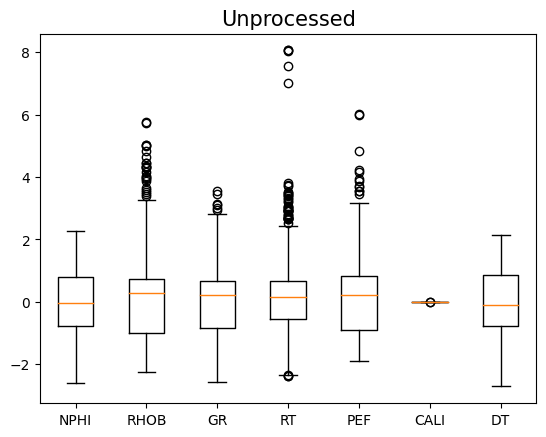

n samples unprocessed: 5237


In [11]:
# Make a copy of train
train_fonly = train_trans.copy()

# Remove WELL, DEPTH
train_fonly = train_fonly.drop(['WELL', 'DEPTH'], axis=1)
train_fonly_names = train_fonly.columns

# Helper function for repeated plotting

def makeboxplot(my_title='enter title',my_data=None):
    _, ax1 = plt.subplots()
    ax1.set_title(my_title, size=15)
    ax1.boxplot(my_data)
    ax1.set_xticklabels(train_fonly_names)
    plt.show()

makeboxplot('Unprocessed',train_trans[train_fonly_names])
print('n samples unprocessed:', len(train_fonly))

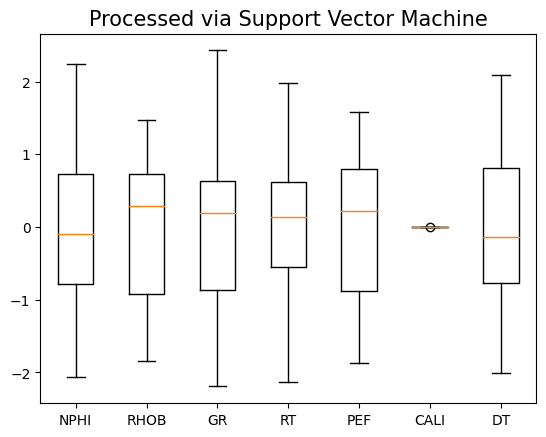

Remaining samples: 4710


In [12]:
svm = OneClassSVM(nu=0.1)
yhat = svm.fit_predict(train_fonly)
mask = yhat != -1
train_svm = train_fonly[mask]

makeboxplot('Processed via Support Vector Machine',train_svm)
print('Remaining samples:', len(train_svm))

In [13]:
feature_names = ['NPHI', 'RHOB', 'GR', 'RT', 'PEF', 'CALI']
target_name = 'DT'


## Train and Validation Prep

In [14]:
# Select columns for features (X) and target (y)
X_train = train_svm[feature_names].values.astype('float32')
y_train = train_svm[target_name].values.reshape(-1, 1).astype('float32')

# Define the validation data
train_trans_copy = train_trans.copy()

train_well_names = ['15_9-F-11A', '15_9-F-1A', '15_9-F-1B']

X_val = []
y_val = []

for i in range(len(train_well_names)):
    # Split the df by log name
    val = train_trans_copy.loc[train_trans_copy['WELL'] == train_well_names[i]].copy()

    # Drop name column
    val.drop(['WELL'], axis=1, inplace=True)

    # Define X_val (feature) and y_val (target) as NumPy arrays
    X_val_ = val[feature_names].values.astype('float32')
    y_val_ = val[target_name].values.reshape(-1, 1).astype('float32')

    X_val.append(X_val_)
    y_val.append(y_val_)

# Save into separate NumPy arrays
X_val1, X_val3, X_val4 = X_val
y_val1, y_val3, y_val4 = y_val

In [15]:
X_train = X_train.astype('float32')

# Cast y_train to float32
y_train = y_train.astype('float32')

# Cast X_val1, X_val3, X_val4 to float32
X_val1 = X_val1.astype('float32')
X_val3 = X_val3.astype('float32')
X_val4 = X_val4.astype('float32')

# Cast y_val1, y_val3, y_val4 to float32
y_val1 = y_val1.astype('float32')
y_val3 = y_val3.astype('float32')
y_val4 = y_val4.astype('float32')

# Data Augmentation

In [17]:
# Select columns for features (X) and target (y)
train_gen = pd.merge(train_svm, train_trans, on = ['NPHI', 'RHOB', 'GR', 'RT', 'PEF', 'CALI', 'DT'], how='left')


In [18]:
train_gen.head()

,NPHI,RHOB,GR,RT,PEF,CALI,DT,WELL,DEPTH
0,1.519175,-0.848053,1.152409,-0.587655,-0.233855,-0.0,1.503613,15_9-F-11A,2600.1
1,1.333845,-0.973097,1.088298,-0.608319,-0.664368,-0.0,1.462887,15_9-F-11A,2600.2
2,1.167632,-1.335892,0.519263,-0.507172,-1.220038,-0.0,1.056418,15_9-F-11A,2600.7
3,1.303354,-1.263767,0.524582,-0.690518,-0.877682,-0.0,1.000025,15_9-F-11A,2600.9
4,1.415735,-1.214693,0.555802,-0.773834,-0.69464,-0.0,1.055461,15_9-F-11A,2601.0


In [19]:
num_features = len(train_gen.drop('WELL', axis = 1).columns)

In [20]:
train_well_names = ['15_9-F-11A', '15_9-F-1A', '15_9-F-1B']

df_gen1 = train_gen[train_gen['WELL'] == '15_9-F-11A'].copy()
df_gen3 = train_gen[train_gen['WELL'] == '15_9-F-1A'].copy()
df_gen4 = train_gen[train_gen['WELL'] == '15_9-F-1B'].copy()

In [21]:
train_gen.head()

,NPHI,RHOB,GR,RT,PEF,CALI,DT,WELL,DEPTH
0,1.519175,-0.848053,1.152409,-0.587655,-0.233855,-0.0,1.503613,15_9-F-11A,2600.1
1,1.333845,-0.973097,1.088298,-0.608319,-0.664368,-0.0,1.462887,15_9-F-11A,2600.2
2,1.167632,-1.335892,0.519263,-0.507172,-1.220038,-0.0,1.056418,15_9-F-11A,2600.7
3,1.303354,-1.263767,0.524582,-0.690518,-0.877682,-0.0,1.000025,15_9-F-11A,2600.9
4,1.415735,-1.214693,0.555802,-0.773834,-0.69464,-0.0,1.055461,15_9-F-11A,2601.0


In [22]:
# Fit and transform the 'DEPTH' column for df_gen1
df_gen1['DEPTH'] = scaler.fit_transform(df_gen1[['DEPTH']])

# Fit and transform the 'DEPTH' column for df_gen3
df_gen3['DEPTH'] = scaler.fit_transform(df_gen3[['DEPTH']])

# Fit and transform the 'DEPTH' column for df_gen4
df_gen4['DEPTH'] = scaler.fit_transform(df_gen4[['DEPTH']])

In [23]:
df_gen1

,NPHI,RHOB,GR,RT,PEF,CALI,DT,WELL,DEPTH
0,1.519175,-0.848053,1.152409,-0.587655,-0.233855,-0.0,1.503613,15_9-F-11A,-1.585251
1,1.333845,-0.973097,1.088298,-0.608319,-0.664368,-0.0,1.462887,15_9-F-11A,-1.584872
2,1.167632,-1.335892,0.519263,-0.507172,-1.220038,-0.0,1.056418,15_9-F-11A,-1.582980
3,1.303354,-1.263767,0.524582,-0.690518,-0.877682,-0.0,1.000025,15_9-F-11A,-1.582223
4,1.415735,-1.214693,0.555802,-0.773834,-0.69464,-0.0,1.055461,15_9-F-11A,-1.581844
...,...,...,...,...,...,...,...,...,...
2413,0.673193,0.908581,1.031413,-0.136037,0.29249,0.0,-0.215553,15_9-F-11A,1.561970
2414,0.580464,1.264872,0.828675,-0.164626,0.926041,0.0,0.016485,15_9-F-11A,1.562812
2415,0.821123,1.083979,1.034591,-0.290352,0.394514,0.0,0.606227,15_9-F-11A,1.564074
2416,0.837765,0.900363,1.102925,-0.359922,0.248884,0.0,0.618953,15_9-F-11A,1.564285


In [24]:
# Define the GAN model architecture
def build_generator(latent_dim, num_features):
    model = models.Sequential()
    model.add(layers.Dense(128, input_dim=latent_dim, activation=None))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(layers.Dense(128, activation=None))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(layers.Dense(256, activation=None))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(layers.Dense(num_features, activation='linear'))  # Output layer
    return model

def build_discriminator(num_features):
    model = models.Sequential()
    model.add(layers.Dense(256, input_shape=(num_features,), activation=None))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(128, activation=None))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(128, activation=None))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(1, activation='sigmoid'))  # Output layer
    return model


In [25]:
generator_loss_fn =  tf.keras.losses.BinaryCrossentropy()
discriminator_loss =  tf.keras.losses.BinaryCrossentropy()



In [26]:
def train_gan(generator, discriminator, epochs, batch_size, data_frame, generator_optimizer, discriminator_optimizer):
    data_frame = data_frame

    # Determine the number of batches
    num_samples = len(data_frame)
    num_batches = num_samples // batch_size

    for epoch in range(epochs):
        avg_gen_loss = 0
        avg_disc_loss = 0
        with tqdm(total=num_batches, desc=f'Epoch {epoch+1}/{epochs}', unit='batch') as pbar:

            for batch in range(num_batches):

                # Get real data for the current batch
                batch_start = batch * batch_size
                batch_end = (batch + 1) * batch_size
                real_data = data_frame.iloc[batch_start:batch_end]
                real_data = real_data.values.astype('float32')

                # Sample random noise for generator input
                noise = np.random.normal(0, 1, size=(len(real_data), latent_dim))

                # Generate synthetic data
                generated_data = generator.predict(noise,  verbose=0)

                # Combine real and generated data
                x_combined = np.concatenate([real_data, generated_data])

                # Labels for real and generated data
                y_real = np.ones((batch_size, 1))
                y_generated = np.zeros((batch_size, 1))
                y_combined = np.concatenate([y_real, y_generated])

                # Train discriminator
                with tf.GradientTape() as disc_tape:
                    # Forward pass: compute logits for real and fake samples
                    real_logits = discriminator(real_data, training=True)
                    fake_logits = discriminator(generated_data, training=True)

                    # Compute discriminator loss
                    real_labels = tf.ones_like(real_logits)
                    fake_labels = tf.zeros_like(fake_logits)
                    discriminator_loss_real = discriminator_loss(real_labels, real_logits)
                    discriminator_loss_fake = discriminator_loss(fake_labels, fake_logits)
                    discriminator_loss_total = (discriminator_loss_real + discriminator_loss_fake)

                # Compute gradients of discriminator loss with respect to discriminator trainable variables
                gradients_of_discriminator = disc_tape.gradient(discriminator_loss_total, discriminator.trainable_variables)

                # Update discriminator weights using optimizer
                discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

                with tf.GradientTape() as gen_tape:
                    # Generate fake samples using the generator
                    fake_samples = generator(noise, training=True)

                    # Compute generator loss
                    generator_loss = generator_loss_fn(real_labels, discriminator(fake_samples, training=True))

                # Compute gradients of generator loss with respect to generator trainable variables
                gradients_of_generator = gen_tape.gradient(generator_loss, generator.trainable_variables)

                # Update generator weights using optimizer
                generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))

                avg_disc_loss += discriminator_loss_total
                avg_gen_loss +=  generator_loss

                pbar.update(1)

            # Print progress
        print(f"Epoch {epoch+1}/{epochs}, Discriminator Loss: {avg_disc_loss/num_batches}, Generator Loss: {avg_gen_loss/num_batches}")


In [27]:
# Generate synthetic data for certain depths
def generate_synthetic_data(generator, num_samples):
    noise = np.random.normal(0, 1, size=(num_samples, latent_dim))
    synthetic_data = generator.predict(noise)
    return synthetic_data


In [28]:
# Train the GAN for log 1
# Define GAN components
latent_dim = 128
generator_1 = build_generator(latent_dim, num_features)
discriminator_1 = build_discriminator(num_features)

generator_optimizer_1 = tf.keras.optimizers.Adam(learning_rate=3e-4)
discriminator_optimizer_1 = tf.keras.optimizers.Adam(learning_rate=3e-4)

epochs = 32
batch_size = 32
num_batches = len(df_gen1) // batch_size
train_gan(generator_1, discriminator_1, epochs, batch_size, df_gen1.drop("WELL", axis = 1), generator_optimizer_1, discriminator_optimizer_1)

Epoch 1/32: 100%|██████████| 75/75 [00:21<00:00,  3.52batch/s]


Epoch 1/32, Discriminator Loss: 1.489890456199646, Generator Loss: 0.7403552532196045


Epoch 2/32: 100%|██████████| 75/75 [00:17<00:00,  4.34batch/s]


Epoch 2/32, Discriminator Loss: 1.4222168922424316, Generator Loss: 0.7085081934928894


Epoch 3/32: 100%|██████████| 75/75 [00:16<00:00,  4.49batch/s]


Epoch 3/32, Discriminator Loss: 1.409940242767334, Generator Loss: 0.7058163285255432


Epoch 4/32: 100%|██████████| 75/75 [00:24<00:00,  3.06batch/s]


Epoch 4/32, Discriminator Loss: 1.406400442123413, Generator Loss: 0.7030065059661865


Epoch 5/32: 100%|██████████| 75/75 [00:15<00:00,  4.78batch/s]


Epoch 5/32, Discriminator Loss: 1.4006208181381226, Generator Loss: 0.7006968855857849


Epoch 6/32: 100%|██████████| 75/75 [00:16<00:00,  4.49batch/s]


Epoch 6/32, Discriminator Loss: 1.3996360301971436, Generator Loss: 0.6998618245124817


Epoch 7/32: 100%|██████████| 75/75 [00:16<00:00,  4.56batch/s]


Epoch 7/32, Discriminator Loss: 1.3961368799209595, Generator Loss: 0.6986135840415955


Epoch 8/32: 100%|██████████| 75/75 [00:15<00:00,  4.77batch/s]


Epoch 8/32, Discriminator Loss: 1.39482843875885, Generator Loss: 0.6981895565986633


Epoch 9/32: 100%|██████████| 75/75 [00:17<00:00,  4.35batch/s]


Epoch 9/32, Discriminator Loss: 1.3938761949539185, Generator Loss: 0.697719395160675


Epoch 10/32: 100%|██████████| 75/75 [00:15<00:00,  4.81batch/s]


Epoch 10/32, Discriminator Loss: 1.3931217193603516, Generator Loss: 0.6970609426498413


Epoch 11/32: 100%|██████████| 75/75 [00:15<00:00,  4.79batch/s]


Epoch 11/32, Discriminator Loss: 1.3923338651657104, Generator Loss: 0.6968176960945129


Epoch 12/32: 100%|██████████| 75/75 [00:16<00:00,  4.48batch/s]


Epoch 12/32, Discriminator Loss: 1.3917454481124878, Generator Loss: 0.6966970562934875


Epoch 13/32: 100%|██████████| 75/75 [00:16<00:00,  4.52batch/s]


Epoch 13/32, Discriminator Loss: 1.391165852546692, Generator Loss: 0.6961931586265564


Epoch 14/32: 100%|██████████| 75/75 [00:15<00:00,  4.80batch/s]


Epoch 14/32, Discriminator Loss: 1.3909541368484497, Generator Loss: 0.6960535049438477


Epoch 15/32: 100%|██████████| 75/75 [00:17<00:00,  4.21batch/s]


Epoch 15/32, Discriminator Loss: 1.3907417058944702, Generator Loss: 0.6956854462623596


Epoch 16/32: 100%|██████████| 75/75 [00:18<00:00,  4.10batch/s]


Epoch 16/32, Discriminator Loss: 1.390474796295166, Generator Loss: 0.695678174495697


Epoch 17/32: 100%|██████████| 75/75 [00:16<00:00,  4.59batch/s]


Epoch 17/32, Discriminator Loss: 1.3900785446166992, Generator Loss: 0.695442795753479


Epoch 18/32: 100%|██████████| 75/75 [00:15<00:00,  4.81batch/s]


Epoch 18/32, Discriminator Loss: 1.3895974159240723, Generator Loss: 0.6953010559082031


Epoch 19/32: 100%|██████████| 75/75 [00:15<00:00,  4.77batch/s]


Epoch 19/32, Discriminator Loss: 1.3896409273147583, Generator Loss: 0.6952675580978394


Epoch 20/32: 100%|██████████| 75/75 [00:16<00:00,  4.63batch/s]


Epoch 20/32, Discriminator Loss: 1.3893004655838013, Generator Loss: 0.6949533224105835


Epoch 21/32: 100%|██████████| 75/75 [00:16<00:00,  4.65batch/s]


Epoch 21/32, Discriminator Loss: 1.3893406391143799, Generator Loss: 0.6949070692062378


Epoch 22/32: 100%|██████████| 75/75 [00:15<00:00,  4.79batch/s]


Epoch 22/32, Discriminator Loss: 1.3893005847930908, Generator Loss: 0.6948524713516235


Epoch 23/32: 100%|██████████| 75/75 [00:15<00:00,  4.71batch/s]


Epoch 23/32, Discriminator Loss: 1.3890619277954102, Generator Loss: 0.6946656107902527


Epoch 24/32: 100%|██████████| 75/75 [00:16<00:00,  4.45batch/s]


Epoch 24/32, Discriminator Loss: 1.3888733386993408, Generator Loss: 0.6945603489875793


Epoch 25/32: 100%|██████████| 75/75 [00:15<00:00,  4.80batch/s]


Epoch 25/32, Discriminator Loss: 1.388636827468872, Generator Loss: 0.6944554448127747


Epoch 26/32: 100%|██████████| 75/75 [00:16<00:00,  4.66batch/s]


Epoch 26/32, Discriminator Loss: 1.3885048627853394, Generator Loss: 0.6944045424461365


Epoch 27/32: 100%|██████████| 75/75 [00:16<00:00,  4.54batch/s]


Epoch 27/32, Discriminator Loss: 1.3885993957519531, Generator Loss: 0.6944037079811096


Epoch 28/32: 100%|██████████| 75/75 [00:15<00:00,  4.73batch/s]


Epoch 28/32, Discriminator Loss: 1.3885561227798462, Generator Loss: 0.6942644119262695


Epoch 29/32: 100%|██████████| 75/75 [00:15<00:00,  4.79batch/s]


Epoch 29/32, Discriminator Loss: 1.3883130550384521, Generator Loss: 0.6943027973175049


Epoch 30/32: 100%|██████████| 75/75 [00:16<00:00,  4.45batch/s]


Epoch 30/32, Discriminator Loss: 1.3887521028518677, Generator Loss: 0.6943094730377197


Epoch 31/32: 100%|██████████| 75/75 [00:15<00:00,  4.76batch/s]


Epoch 31/32, Discriminator Loss: 1.388999104499817, Generator Loss: 0.6943042874336243


Epoch 32/32: 100%|██████████| 75/75 [00:15<00:00,  4.74batch/s]

Epoch 32/32, Discriminator Loss: 1.3892617225646973, Generator Loss: 0.6944268941879272


In [29]:
latent_dim = 128

generator_3 = build_generator(latent_dim, num_features)
discriminator_3 = build_discriminator(num_features)

generator_optimizer_3 = tf.keras.optimizers.Adam(learning_rate=3e-4)
discriminator_optimizer_3 = tf.keras.optimizers.Adam(learning_rate=3e-4)


epochs = 32
batch_size = 32
num_batches = len(df_gen3) // batch_size

train_gan(generator_3, discriminator_3, epochs, batch_size, df_gen3.drop("WELL", axis = 1), generator_optimizer_3, discriminator_optimizer_3)

Epoch 1/32: 100%|██████████| 61/61 [00:16<00:00,  3.80batch/s]


Epoch 1/32, Discriminator Loss: 1.4814609289169312, Generator Loss: 0.7381417751312256


Epoch 2/32: 100%|██████████| 61/61 [00:12<00:00,  4.75batch/s]


Epoch 2/32, Discriminator Loss: 1.421644926071167, Generator Loss: 0.7116512656211853


Epoch 3/32: 100%|██████████| 61/61 [00:12<00:00,  4.72batch/s]


Epoch 3/32, Discriminator Loss: 1.407720923423767, Generator Loss: 0.7060437798500061


Epoch 4/32: 100%|██████████| 61/61 [00:13<00:00,  4.37batch/s]


Epoch 4/32, Discriminator Loss: 1.4039069414138794, Generator Loss: 0.7031301856040955


Epoch 5/32: 100%|██████████| 61/61 [00:12<00:00,  4.77batch/s]


Epoch 5/32, Discriminator Loss: 1.399493932723999, Generator Loss: 0.7010568380355835


Epoch 6/32: 100%|██████████| 61/61 [00:13<00:00,  4.56batch/s]


Epoch 6/32, Discriminator Loss: 1.3976432085037231, Generator Loss: 0.6998340487480164


Epoch 7/32: 100%|██████████| 61/61 [00:13<00:00,  4.63batch/s]


Epoch 7/32, Discriminator Loss: 1.3969261646270752, Generator Loss: 0.6993381381034851


Epoch 8/32: 100%|██████████| 61/61 [00:13<00:00,  4.62batch/s]


Epoch 8/32, Discriminator Loss: 1.3957635164260864, Generator Loss: 0.699102520942688


Epoch 9/32: 100%|██████████| 61/61 [00:13<00:00,  4.52batch/s]


Epoch 9/32, Discriminator Loss: 1.3945413827896118, Generator Loss: 0.6981164813041687


Epoch 10/32: 100%|██████████| 61/61 [00:13<00:00,  4.65batch/s]


Epoch 10/32, Discriminator Loss: 1.393505573272705, Generator Loss: 0.6976573467254639


Epoch 11/32: 100%|██████████| 61/61 [00:13<00:00,  4.60batch/s]


Epoch 11/32, Discriminator Loss: 1.392722725868225, Generator Loss: 0.6975454688072205


Epoch 12/32: 100%|██████████| 61/61 [00:12<00:00,  4.72batch/s]


Epoch 12/32, Discriminator Loss: 1.3921808004379272, Generator Loss: 0.6970587968826294


Epoch 13/32: 100%|██████████| 61/61 [00:12<00:00,  4.72batch/s]


Epoch 13/32, Discriminator Loss: 1.3918098211288452, Generator Loss: 0.6968616843223572


Epoch 14/32: 100%|██████████| 61/61 [00:13<00:00,  4.67batch/s]


Epoch 14/32, Discriminator Loss: 1.3912911415100098, Generator Loss: 0.6964254379272461


Epoch 15/32: 100%|██████████| 61/61 [00:13<00:00,  4.64batch/s]


Epoch 15/32, Discriminator Loss: 1.3908313512802124, Generator Loss: 0.6960501074790955


Epoch 16/32: 100%|██████████| 61/61 [00:12<00:00,  4.74batch/s]


Epoch 16/32, Discriminator Loss: 1.3904489278793335, Generator Loss: 0.6960713863372803


Epoch 17/32: 100%|██████████| 61/61 [00:13<00:00,  4.49batch/s]


Epoch 17/32, Discriminator Loss: 1.390190839767456, Generator Loss: 0.6958560347557068


Epoch 18/32: 100%|██████████| 61/61 [00:12<00:00,  4.77batch/s]


Epoch 18/32, Discriminator Loss: 1.3902946710586548, Generator Loss: 0.6959435343742371


Epoch 19/32: 100%|██████████| 61/61 [00:12<00:00,  4.76batch/s]


Epoch 19/32, Discriminator Loss: 1.390268087387085, Generator Loss: 0.6957128643989563


Epoch 20/32: 100%|██████████| 61/61 [00:13<00:00,  4.61batch/s]


Epoch 20/32, Discriminator Loss: 1.3905316591262817, Generator Loss: 0.6957951188087463


Epoch 21/32: 100%|██████████| 61/61 [00:13<00:00,  4.52batch/s]


Epoch 21/32, Discriminator Loss: 1.390331506729126, Generator Loss: 0.6954455971717834


Epoch 22/32: 100%|██████████| 61/61 [00:13<00:00,  4.45batch/s]


Epoch 22/32, Discriminator Loss: 1.390061616897583, Generator Loss: 0.6952933669090271


Epoch 23/32: 100%|██████████| 61/61 [00:13<00:00,  4.54batch/s]


Epoch 23/32, Discriminator Loss: 1.389422059059143, Generator Loss: 0.6949523091316223


Epoch 24/32: 100%|██████████| 61/61 [00:13<00:00,  4.68batch/s]


Epoch 24/32, Discriminator Loss: 1.3890461921691895, Generator Loss: 0.6948713660240173


Epoch 25/32: 100%|██████████| 61/61 [00:12<00:00,  4.72batch/s]


Epoch 25/32, Discriminator Loss: 1.3889949321746826, Generator Loss: 0.6948076486587524


Epoch 26/32: 100%|██████████| 61/61 [00:12<00:00,  4.75batch/s]


Epoch 26/32, Discriminator Loss: 1.388763189315796, Generator Loss: 0.6948038339614868


Epoch 27/32: 100%|██████████| 61/61 [00:13<00:00,  4.57batch/s]


Epoch 27/32, Discriminator Loss: 1.3886138200759888, Generator Loss: 0.6945621371269226


Epoch 28/32: 100%|██████████| 61/61 [00:12<00:00,  4.71batch/s]


Epoch 28/32, Discriminator Loss: 1.3884466886520386, Generator Loss: 0.6945574879646301


Epoch 29/32: 100%|██████████| 61/61 [00:12<00:00,  4.71batch/s]


Epoch 29/32, Discriminator Loss: 1.388505458831787, Generator Loss: 0.6945408582687378


Epoch 30/32: 100%|██████████| 61/61 [00:12<00:00,  4.70batch/s]


Epoch 30/32, Discriminator Loss: 1.388537049293518, Generator Loss: 0.6945840120315552


Epoch 31/32: 100%|██████████| 61/61 [00:13<00:00,  4.42batch/s]


Epoch 31/32, Discriminator Loss: 1.3886207342147827, Generator Loss: 0.6945431232452393


Epoch 32/32: 100%|██████████| 61/61 [00:13<00:00,  4.61batch/s]

Epoch 32/32, Discriminator Loss: 1.3889508247375488, Generator Loss: 0.6944507360458374


In [30]:
latent_dim = 128

generator_4 = build_generator(latent_dim, num_features)
discriminator_4 = build_discriminator(num_features)

generator_optimizer_4 = tf.keras.optimizers.Adam(learning_rate=3e-4)
discriminator_optimizer_4 = tf.keras.optimizers.Adam(learning_rate=3e-4)


epochs = 32
batch_size = 32
num_batches = len(df_gen4) // batch_size

train_gan(generator_4, discriminator_4, epochs, batch_size, df_gen4.drop("WELL", axis = 1), generator_optimizer_4, discriminator_optimizer_4)

Epoch 1/32: 100%|██████████| 10/10 [00:05<00:00,  1.85batch/s]


Epoch 1/32, Discriminator Loss: 1.5897419452667236, Generator Loss: 0.7796352505683899


Epoch 2/32: 100%|██████████| 10/10 [00:01<00:00,  5.07batch/s]


Epoch 2/32, Discriminator Loss: 1.5229847431182861, Generator Loss: 0.7475086450576782


Epoch 3/32: 100%|██████████| 10/10 [00:02<00:00,  4.99batch/s]


Epoch 3/32, Discriminator Loss: 1.4603487253189087, Generator Loss: 0.7474680542945862


Epoch 4/32: 100%|██████████| 10/10 [00:01<00:00,  5.13batch/s]


Epoch 4/32, Discriminator Loss: 1.4374881982803345, Generator Loss: 0.7346441149711609


Epoch 5/32: 100%|██████████| 10/10 [00:01<00:00,  5.06batch/s]


Epoch 5/32, Discriminator Loss: 1.4276617765426636, Generator Loss: 0.7293364405632019


Epoch 6/32: 100%|██████████| 10/10 [00:02<00:00,  3.82batch/s]


Epoch 6/32, Discriminator Loss: 1.419032096862793, Generator Loss: 0.7251323461532593


Epoch 7/32: 100%|██████████| 10/10 [00:02<00:00,  4.26batch/s]


Epoch 7/32, Discriminator Loss: 1.4134652614593506, Generator Loss: 0.7222860455513


Epoch 8/32: 100%|██████████| 10/10 [00:02<00:00,  4.64batch/s]


Epoch 8/32, Discriminator Loss: 1.4162226915359497, Generator Loss: 0.7179490327835083


Epoch 9/32: 100%|██████████| 10/10 [00:02<00:00,  4.80batch/s]


Epoch 9/32, Discriminator Loss: 1.4141182899475098, Generator Loss: 0.7187937498092651


Epoch 10/32: 100%|██████████| 10/10 [00:02<00:00,  4.78batch/s]


Epoch 10/32, Discriminator Loss: 1.411268711090088, Generator Loss: 0.7153639197349548


Epoch 11/32: 100%|██████████| 10/10 [00:02<00:00,  4.03batch/s]


Epoch 11/32, Discriminator Loss: 1.4092562198638916, Generator Loss: 0.7131811380386353


Epoch 12/32: 100%|██████████| 10/10 [00:02<00:00,  4.34batch/s]


Epoch 12/32, Discriminator Loss: 1.4071369171142578, Generator Loss: 0.7158180475234985


Epoch 13/32: 100%|██████████| 10/10 [00:02<00:00,  4.88batch/s]


Epoch 13/32, Discriminator Loss: 1.406495451927185, Generator Loss: 0.7124202847480774


Epoch 14/32: 100%|██████████| 10/10 [00:02<00:00,  4.75batch/s]


Epoch 14/32, Discriminator Loss: 1.4070242643356323, Generator Loss: 0.7125444412231445


Epoch 15/32: 100%|██████████| 10/10 [00:02<00:00,  4.83batch/s]


Epoch 15/32, Discriminator Loss: 1.4048858880996704, Generator Loss: 0.7090753316879272


Epoch 16/32: 100%|██████████| 10/10 [00:02<00:00,  4.67batch/s]


Epoch 16/32, Discriminator Loss: 1.4057104587554932, Generator Loss: 0.7105082273483276


Epoch 17/32: 100%|██████████| 10/10 [00:02<00:00,  3.76batch/s]


Epoch 17/32, Discriminator Loss: 1.4075132608413696, Generator Loss: 0.7091621160507202


Epoch 18/32: 100%|██████████| 10/10 [00:02<00:00,  4.82batch/s]


Epoch 18/32, Discriminator Loss: 1.4100319147109985, Generator Loss: 0.7076151371002197


Epoch 19/32: 100%|██████████| 10/10 [00:02<00:00,  4.78batch/s]


Epoch 19/32, Discriminator Loss: 1.4127227067947388, Generator Loss: 0.7106724977493286


Epoch 20/32: 100%|██████████| 10/10 [00:02<00:00,  4.89batch/s]


Epoch 20/32, Discriminator Loss: 1.4199572801589966, Generator Loss: 0.7112199664115906


Epoch 21/32: 100%|██████████| 10/10 [00:02<00:00,  4.84batch/s]


Epoch 21/32, Discriminator Loss: 1.415804386138916, Generator Loss: 0.708663821220398


Epoch 22/32: 100%|██████████| 10/10 [00:02<00:00,  3.88batch/s]


Epoch 22/32, Discriminator Loss: 1.4102632999420166, Generator Loss: 0.7072020173072815


Epoch 23/32: 100%|██████████| 10/10 [00:02<00:00,  4.45batch/s]


Epoch 23/32, Discriminator Loss: 1.406477451324463, Generator Loss: 0.7075303196907043


Epoch 24/32: 100%|██████████| 10/10 [00:02<00:00,  4.79batch/s]


Epoch 24/32, Discriminator Loss: 1.402801513671875, Generator Loss: 0.7065520286560059


Epoch 25/32: 100%|██████████| 10/10 [00:02<00:00,  4.82batch/s]


Epoch 25/32, Discriminator Loss: 1.3996988534927368, Generator Loss: 0.7019539475440979


Epoch 26/32: 100%|██████████| 10/10 [00:02<00:00,  4.86batch/s]


Epoch 26/32, Discriminator Loss: 1.4003770351409912, Generator Loss: 0.7049763798713684


Epoch 27/32: 100%|██████████| 10/10 [00:02<00:00,  4.94batch/s]


Epoch 27/32, Discriminator Loss: 1.4016131162643433, Generator Loss: 0.7042949199676514


Epoch 28/32: 100%|██████████| 10/10 [00:02<00:00,  3.75batch/s]


Epoch 28/32, Discriminator Loss: 1.398078203201294, Generator Loss: 0.7024885416030884


Epoch 29/32: 100%|██████████| 10/10 [00:02<00:00,  4.91batch/s]


Epoch 29/32, Discriminator Loss: 1.3981788158416748, Generator Loss: 0.7033305764198303


Epoch 30/32: 100%|██████████| 10/10 [00:02<00:00,  4.94batch/s]


Epoch 30/32, Discriminator Loss: 1.399239420890808, Generator Loss: 0.7033507227897644


Epoch 31/32: 100%|██████████| 10/10 [00:02<00:00,  4.85batch/s]


Epoch 31/32, Discriminator Loss: 1.3971593379974365, Generator Loss: 0.7028703093528748


Epoch 32/32: 100%|██████████| 10/10 [00:02<00:00,  4.92batch/s]

Epoch 32/32, Discriminator Loss: 1.3992278575897217, Generator Loss: 0.7038174867630005


In [31]:
# Example usage: generate synthetic data for 100 samples
synthetic_data_1 = generate_synthetic_data(generator_1, int(len(df_gen1)*0.33))

25/25 [==============================] - 0s 2ms/step


In [32]:
# Example usage: generate synthetic data for 100 samples
synthetic_data_3 = generate_synthetic_data(generator_3, int(len(df_gen3)*0.33))

21/21 [==============================] - 0s 5ms/step


In [33]:
# Example usage: generate synthetic data for 100 samples
synthetic_data_4 = generate_synthetic_data(generator_4, int(len(df_gen4)*0.33))

4/4 [==============================] - 0s 3ms/step


In [34]:
columns = ['NPHI', 'RHOB', 'GR', 'RT', 'PEF', 'CALI', 'DT', 'DEPTH']

synthetic_df_1 = pd.DataFrame(synthetic_data_1, columns=columns)
synthetic_df_3 = pd.DataFrame(synthetic_data_3, columns=columns)
synthetic_df_4 = pd.DataFrame(synthetic_data_4, columns=columns)


In [35]:
df_gen1.drop('WELL', axis = 1). apply(lambda x: x.astype('float32')).describe()

,NPHI,RHOB,GR,RT,PEF,CALI,DT,DEPTH
count,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2.418000e+03,2418.000000,2418.000000
mean,0.020878,-0.096919,-0.128279,-0.013033,0.144823,3.018333e-17,0.041714,0.000000
std,0.998615,0.956748,0.940370,0.923892,1.021612,8.874725e-17,1.042392,1.000207
min,-1.836181,-1.844921,-2.183082,-2.134081,-1.682039,-2.636780e-16,-2.003131,-1.585251
25%,-0.839134,-1.208502,-0.935719,-0.468226,-0.902275,-2.775558e-17,-0.837915,-0.876773
50%,-0.068158,0.252000,0.096458,0.201377,0.511992,2.775558e-17,-0.096731,-0.055675
75%,0.837765,0.712696,0.555578,0.678175,1.100754,1.110223e-16,0.904615,0.990544
max,2.105063,1.370760,2.287340,1.982535,1.586926,3.053113e-16,2.055941,1.564705


In [36]:
scaler.fit(train_gen[train_gen['WELL'] == '15_9-F-11A']['DEPTH'].values.reshape(-1, 1))
df_gen1['DEPTH'] = scaler.inverse_transform(df_gen1['DEPTH'].values.reshape(-1, 1))
synthetic_df_1['DEPTH'] = scaler.inverse_transform(synthetic_df_1['DEPTH'].values.reshape(-1, 1))

scaler.fit(train_gen[train_gen['WELL'] == '15_9-F-1A']['DEPTH'].values.reshape(-1, 1))
df_gen3['DEPTH'] = scaler.inverse_transform(df_gen3['DEPTH'].values.reshape(-1, 1))
synthetic_df_3['DEPTH'] = scaler.inverse_transform(synthetic_df_3['DEPTH'].values.reshape(-1, 1))


scaler.fit(train_gen[train_gen['WELL'] == '15_9-F-1B']['DEPTH'].values.reshape(-1, 1))
df_gen4['DEPTH'] = scaler.inverse_transform(df_gen4['DEPTH'].values.reshape(-1, 1))
synthetic_df_4['DEPTH'] = scaler.inverse_transform(synthetic_df_4['DEPTH'].values.reshape(-1, 1))


In [37]:
synthetic_df_1.describe()

,NPHI,RHOB,GR,RT,PEF,CALI,DT,DEPTH
count,797.000000,797.000000,797.000000,797.000000,797.000000,797.000000,797.000000,797.000000
mean,1.410549,0.771266,-0.727691,0.094996,-0.267254,-0.966660,-1.411393,3374.221436
std,1.391133,1.290347,1.733024,1.012969,1.207428,0.800820,0.937893,322.679565
min,-2.910874,-3.196633,-5.887568,-2.464205,-4.460712,-4.086168,-5.337459,2558.418701
25%,0.433232,-0.156251,-1.991391,-0.628520,-1.088141,-1.426122,-1.962860,3148.792969
50%,1.315227,0.698082,-0.845374,0.066952,-0.238026,-0.926700,-1.369621,3331.344238
75%,2.287536,1.630634,0.332047,0.750213,0.531105,-0.418322,-0.841927,3582.681641
max,5.785827,4.860806,4.487986,3.232131,3.274179,1.285120,1.429761,4477.438477


In [38]:
df_gen3.head()

,NPHI,RHOB,GR,RT,PEF,CALI,DT,WELL,DEPTH
2418,1.163564,-0.252221,0.796974,-0.021701,-0.586557,-0.0,0.618113,15_9-F-1A,2620.3
2419,1.084851,-0.492849,0.818936,-0.219612,-0.546378,-0.0,0.610256,15_9-F-1A,2620.4
2420,0.905994,-0.760595,0.867667,0.265991,0.390377,-0.0,0.625965,15_9-F-1A,2620.6
2421,1.058189,-0.456094,0.143051,0.032614,-0.912181,-0.0,0.714729,15_9-F-1A,2621.0
2422,1.004249,-1.496987,0.505638,0.320288,-1.651737,-0.0,1.056782,15_9-F-1A,2624.5


In [39]:
synthetic_df_1['WELL'] = '15_9-F-11A'
synthetic_df_3['WELL'] = '15_9-F-1A'
synthetic_df_4['WELL'] = '15_9-F-1B'

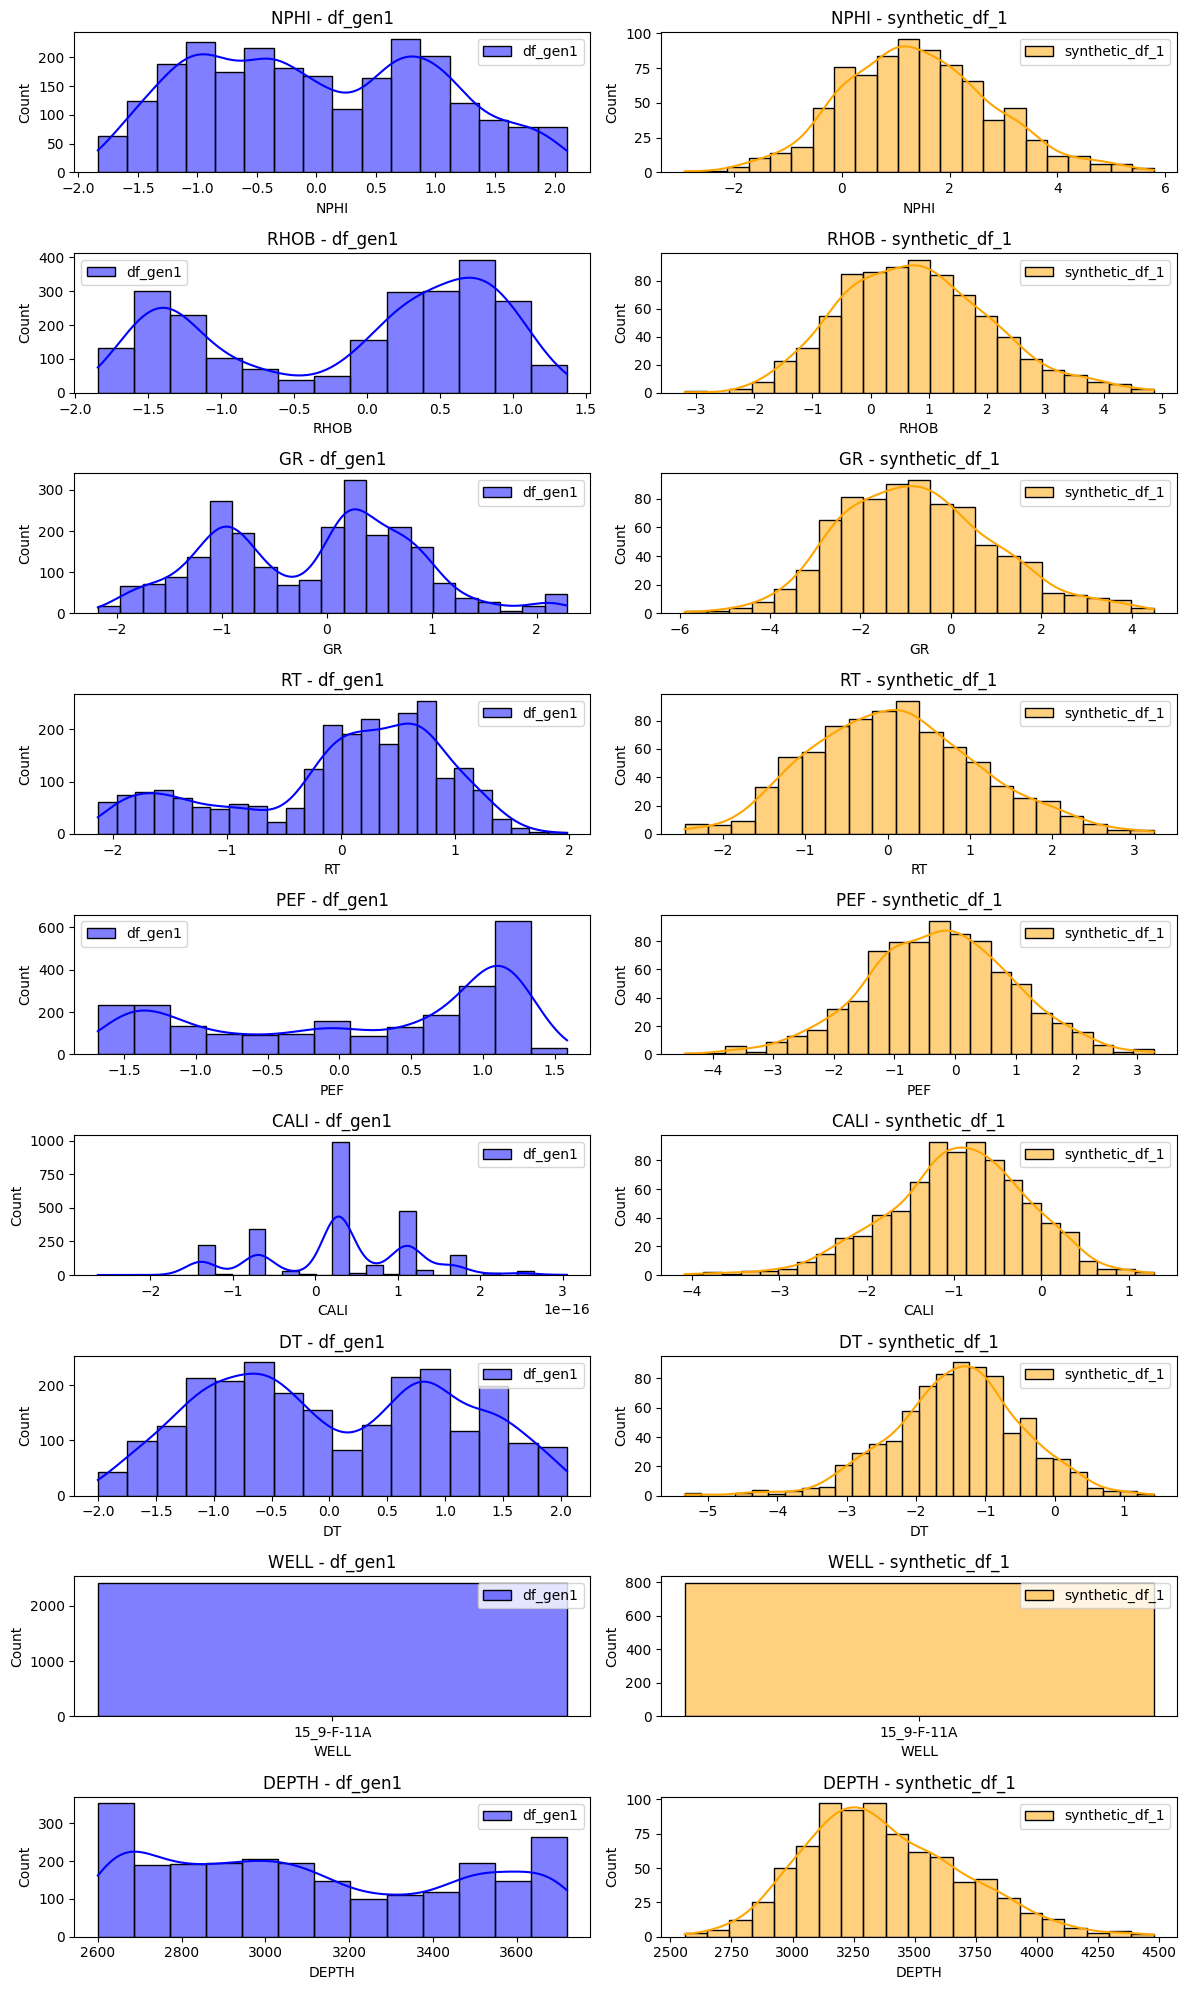

In [40]:
fig, axes = plt.subplots(nrows=len(df_gen1.columns), ncols=2, figsize=(12, 20))
fig.subplots_adjust(hspace=0.5)

# Plot histograms for each feature in df_gen1 and synthetic_df_1
for i, column in enumerate(df_gen1.columns):
    sns.histplot(df_gen1[column], ax=axes[i, 0], kde=True, color='blue', label='df_gen1')
    axes[i, 0].set_title(f'{column} - df_gen1')
    axes[i, 0].legend()

    sns.histplot(synthetic_df_1[column], ax=axes[i, 1], kde=True, color='orange', label='synthetic_df_1')
    axes[i, 1].set_title(f'{column} - synthetic_df_1')
    axes[i, 1].legend()

plt.tight_layout()
plt.show()

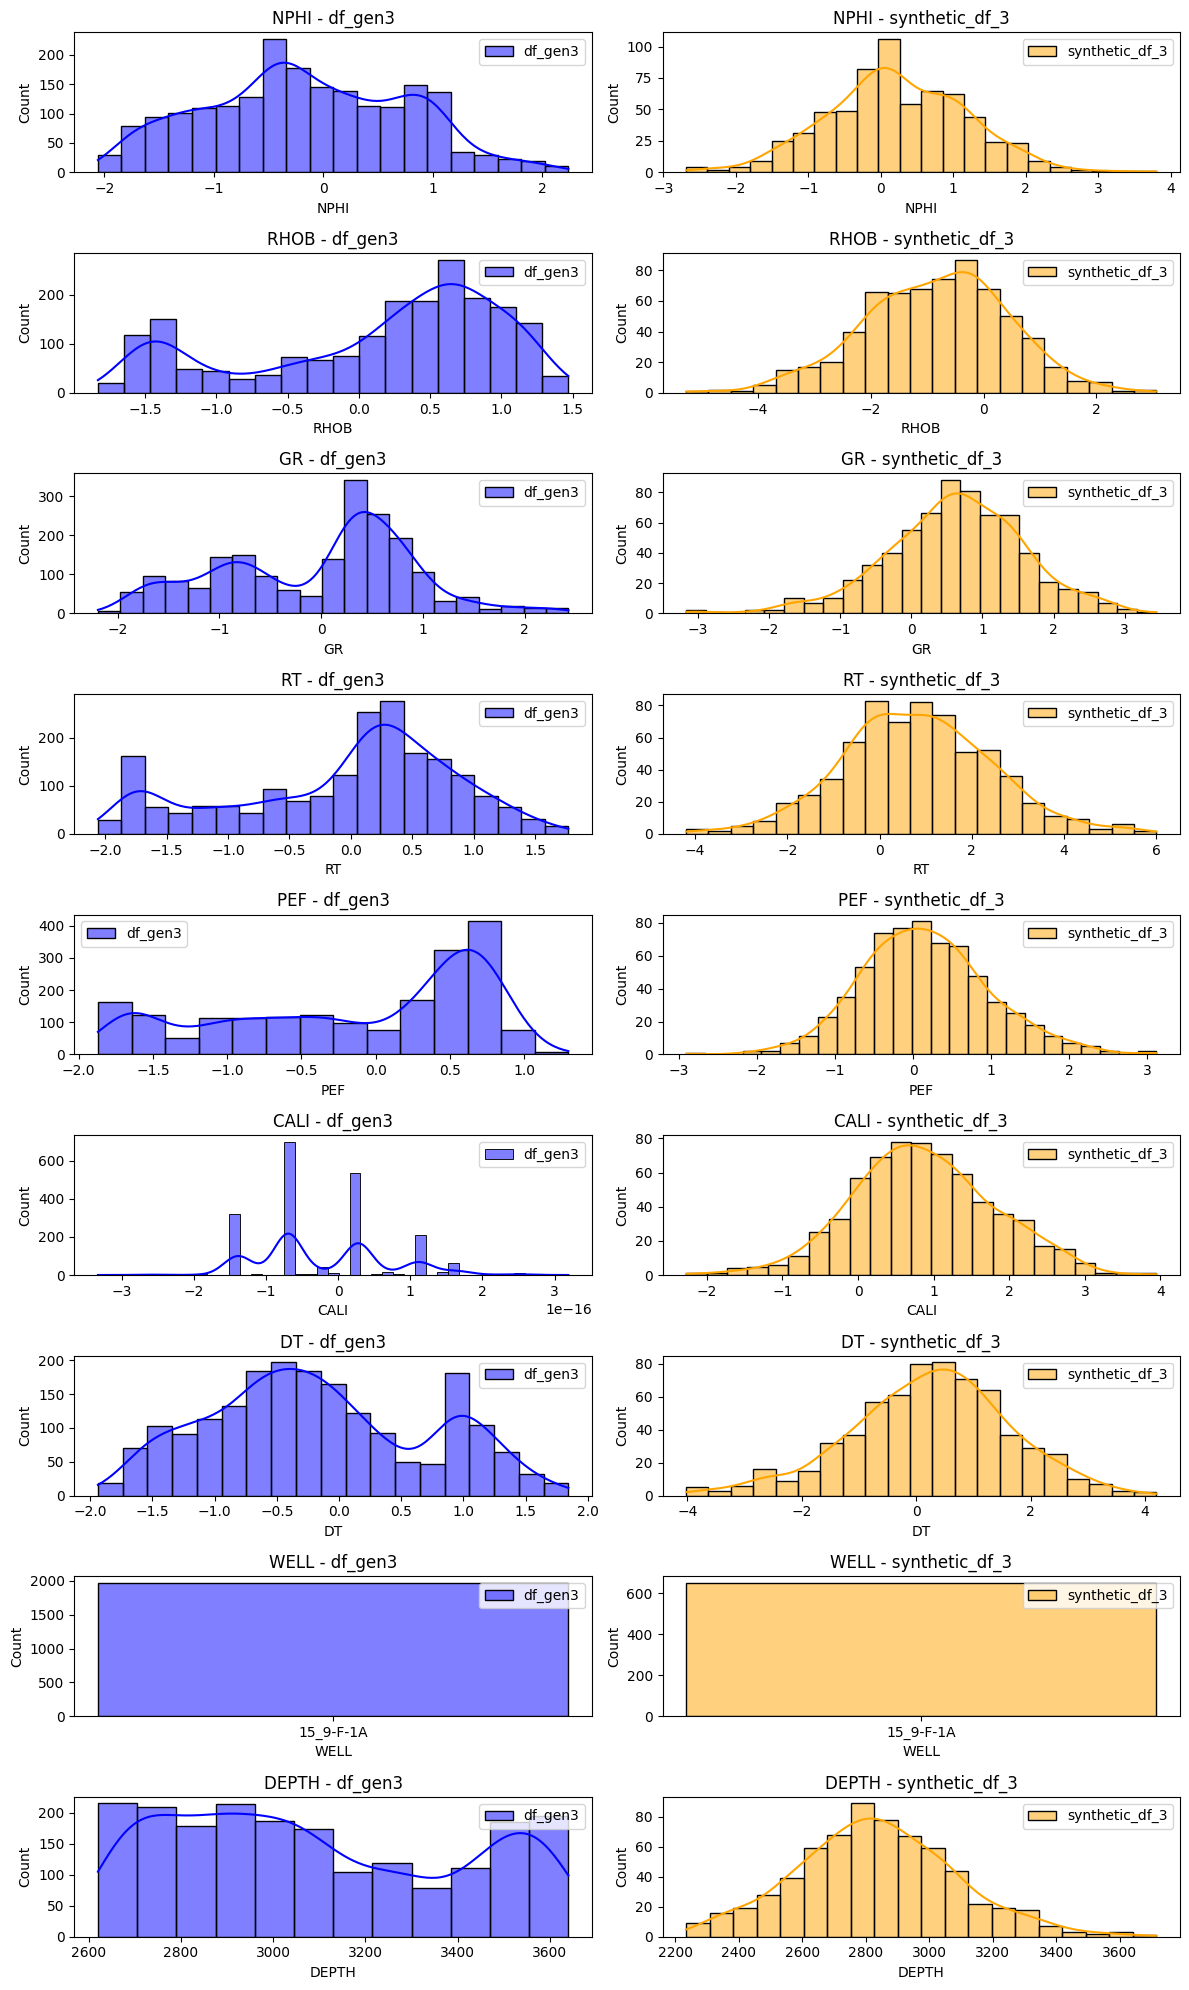

In [41]:
fig, axes = plt.subplots(nrows=len(df_gen3.columns), ncols=2, figsize=(12, 20))
fig.subplots_adjust(hspace=0.5)

# Plot histograms for each feature in df_gen3 and synthetic_df_3
for i, column in enumerate(df_gen3.columns):
    sns.histplot(df_gen3[column], ax=axes[i, 0], kde=True, color='blue', label='df_gen3')
    axes[i, 0].set_title(f'{column} - df_gen3')
    axes[i, 0].legend()

    sns.histplot(synthetic_df_3[column], ax=axes[i, 1], kde=True, color='orange', label='synthetic_df_3')
    axes[i, 1].set_title(f'{column} - synthetic_df_3')
    axes[i, 1].legend()

plt.tight_layout()
plt.show()

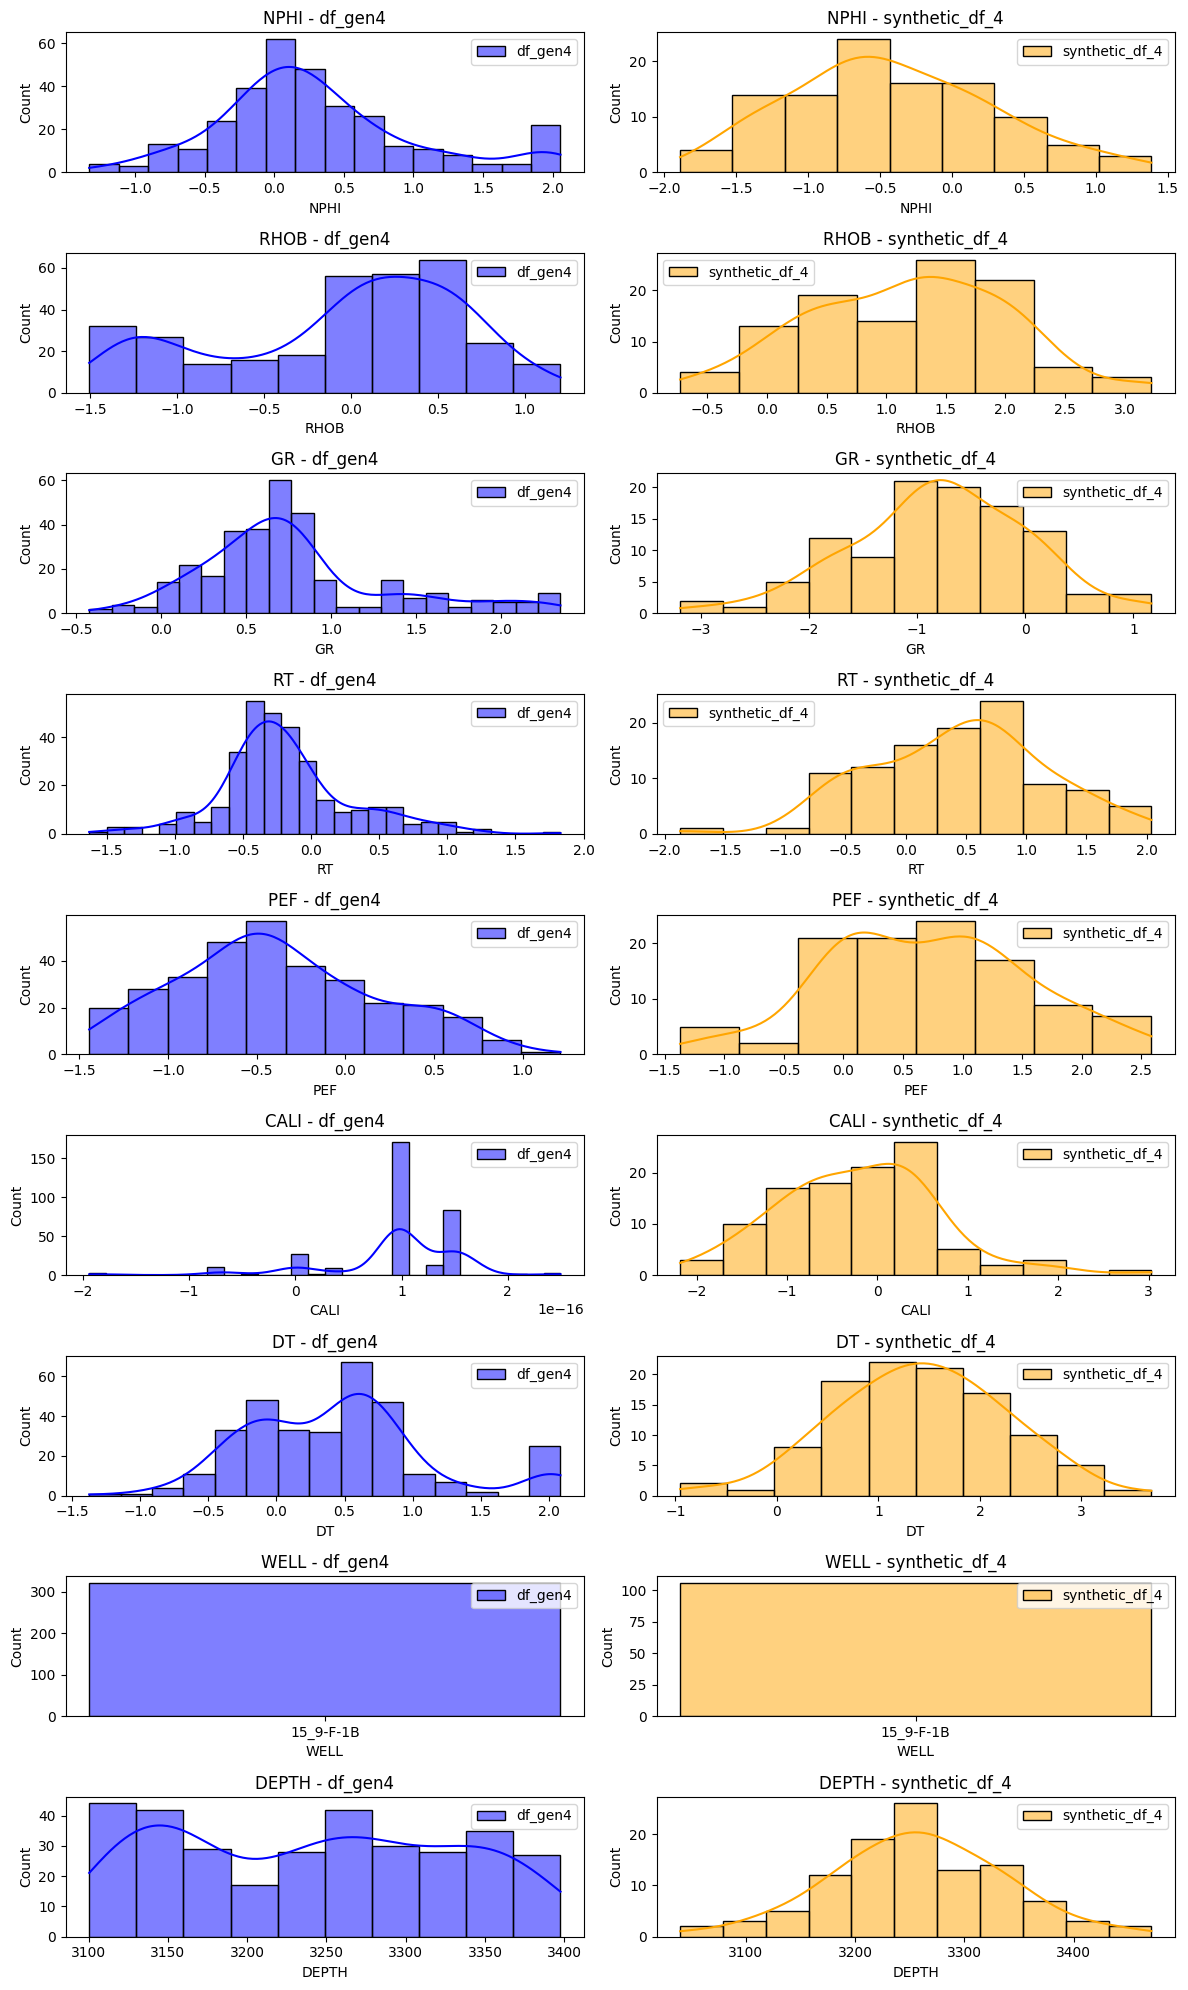

In [42]:
fig, axes = plt.subplots(nrows=len(df_gen4.columns), ncols=2, figsize=(12, 20))
fig.subplots_adjust(hspace=0.5)

# Plot histograms for each feature in df_gen1 and synthetic_df_4
for i, column in enumerate(df_gen4.columns):
    sns.histplot(df_gen4[column], ax=axes[i, 0], kde=True, color='blue', label='df_gen4')
    axes[i, 0].set_title(f'{column} - df_gen4')
    axes[i, 0].legend()

    sns.histplot(synthetic_df_4[column], ax=axes[i, 1], kde=True, color='orange', label='synthetic_df_4')
    axes[i, 1].set_title(f'{column} - synthetic_df_4')
    axes[i, 1].legend()

plt.tight_layout()
plt.show()

In [43]:
df_gen1 = pd.concat([df_gen1, synthetic_df_1])
df_gen1 = df_gen1.sort_values(by='DEPTH')

df_gen3 = pd.concat([df_gen1, synthetic_df_3])
df_gen3  = df_gen3.sort_values(by='DEPTH')

df_gen4 = pd.concat([df_gen1, synthetic_df_4])
df_gen4 = df_gen4.sort_values(by='DEPTH')




In [44]:
X_train_new = pd.concat([df_gen1, df_gen3, df_gen4])
y_train_new = X_train_new['DT']
X_train_new.drop(['DT', 'WELL', 'DEPTH'], axis = 1, inplace= True)

y_train_new = y_train_new.values.reshape(-1,1).astype('float32')
X_train_new = X_train_new.values.astype('float32')

### Decison Tree Regressor


In [45]:
# Decision Tree Regressor object
model_decision_tree = DecisionTreeRegressor()

# Fit the regressor to the training data
model_decision_tree.fit(X_train_new, y_train_new)

# Validation: Predict on well 1
y_pred1_decision_tree = model_decision_tree.predict(X_val1)
print("R2 Log 1: {}".format(round(model_decision_tree.score(X_val1, y_val1), 4)))
rmse = np.sqrt(mean_squared_error(y_val1, y_pred1_decision_tree))
print("RMSE Log 1: {}".format(round(rmse, 4)))

# Validation: Predict on well 3
y_pred3_decision_tree = model_decision_tree.predict(X_val3)
print("R2 Log 3: {}".format(round(model_decision_tree.score(X_val3, y_val3), 4)))
rmse = np.sqrt(mean_squared_error(y_val3, y_pred3_decision_tree))
print("RMSE Log 3: {}".format(round(rmse, 4)))

# Validation: Predict on well 4
y_pred4_decision_tree = model_decision_tree.predict(X_val4)
print("R2 Log 4: {}".format(round(model_decision_tree.score(X_val4, y_val4), 4)))
rmse = np.sqrt(mean_squared_error(y_val4, y_pred4_decision_tree))
print("RMSE Log 4: {}".format(round(rmse, 4)))


R2 Log 1: 0.8238
RMSE Log 1: 0.4537
R2 Log 3: 0.5237
RMSE Log 3: 0.6244
R2 Log 4: -1.0967
RMSE Log 4: 1.0136


### Gradient Booster Regressor

In [46]:
# Gradient Booster object
model_grad_boost = GradientBoostingRegressor()

# Fit the regressor to the training data
model_grad_boost.fit(X_train_new, y_train_new)

# Validation: Predict on well 1
y_pred1_grad_boost = model_grad_boost.predict(X_val1)
print("R2 Log 1: {}".format(round(model_grad_boost.score(X_val1, y_val1),4)))
rmse = np.sqrt(mean_squared_error(y_val1, y_pred1_grad_boost))
print("RMSE Log 1: {}".format(round(rmse,4)))

# Validation: Predict on well 3
y_pred3_grad_boost = model_grad_boost.predict(X_val3)
print("R2 Log 3: {}".format(round(model_grad_boost.score(X_val3, y_val3),4)))
rmse = np.sqrt(mean_squared_error(y_val3, y_pred3_grad_boost))
print("RMSE Log 3: {}".format(round(rmse,4)))

# Validation: Predict on well 4
y_pred4_grad_boost = model_grad_boost.predict(X_val4)
print("R2 Log 4: {}".format(round(model_grad_boost.score(X_val4, y_val4),4)))
rmse = np.sqrt(mean_squared_error(y_val4, y_pred4_grad_boost))
print("RMSE Log 4: {}".format(round(rmse,4)))

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


R2 Log 1: 0.8912
RMSE Log 1: 0.3565
R2 Log 3: 0.8124
RMSE Log 3: 0.3919
R2 Log 4: 0.3549
RMSE Log 4: 0.5623


### Neural Network

In [47]:
# Define the neural network model
def neural_network_model(input_shape):
    model = Sequential([
        Dense(64, activation='relu', input_shape=input_shape),
        Dense(64, activation='relu'),
        Dense(64, activation='relu'),
        Dense(1)  # Output layer
    ])
    return model

# Initialize and compile the neural network model
model_nn = neural_network_model(X_train_new.shape[1:])
model_nn.compile(optimizer='adam', loss='mean_squared_error')

# Fit the neural network model to the training data
history_nn = model_nn.fit(X_train_new, y_train_new, epochs=16, batch_size=32, validation_data=(X_val1, y_val1))

# Validation: Predict on well 1
y_pred1_nn = model_nn.predict(X_val1)
rmse_nn1 = np.sqrt(mean_squared_error(y_val1, y_pred1_nn))
print("RMSE Neural Network Log 1: {}".format(round(rmse_nn1, 4)))

# Validation: Predict on well 3
y_pred3_nn = model_nn.predict(X_val3)
rmse_nn3 = np.sqrt(mean_squared_error(y_val3, y_pred3_nn))
print("RMSE Neural Network Log 3: {}".format(round(rmse_nn3, 4)))

# Validation: Predict on well 4
y_pred4_nn = model_nn.predict(X_val4)
rmse_nn4 = np.sqrt(mean_squared_error(y_val4, y_pred4_nn))
print("RMSE Neural Network Log 4: {}".format(round(rmse_nn4, 4)))


Epoch 1/16
326/326 [==============================] - 3s 4ms/step - loss: 0.3597 - val_loss: 0.1051
Epoch 2/16
326/326 [==============================] - 1s 4ms/step - loss: 0.2788 - val_loss: 0.1068
Epoch 3/16
326/326 [==============================] - 1s 4ms/step - loss: 0.2663 - val_loss: 0.0893
Epoch 4/16
326/326 [==============================] - 1s 4ms/step - loss: 0.2559 - val_loss: 0.0918
Epoch 5/16
326/326 [==============================] - 1s 4ms/step - loss: 0.2482 - val_loss: 0.0933
Epoch 6/16
326/326 [==============================] - 1s 3ms/step - loss: 0.2438 - val_loss: 0.0981
Epoch 7/16
326/326 [==============================] - 2s 5ms/step - loss: 0.2391 - val_loss: 0.0995
Epoch 8/16
326/326 [==============================] - 1s 5ms/step - loss: 0.2314 - val_loss: 0.0998
Epoch 9/16
326/326 [==============================] - 1s 4ms/step - loss: 0.2276 - val_loss: 0.1044
Epoch 10/16
326/326 [==============================] - 1s 4ms/step - loss: 0.2222 - val_loss: 0.0955

### LSTM

In [48]:
# Preparing data for LSTM
time_steps = 10

def prep_for_lstm(X_in, y_in, time_steps = 10):
    X_lstm = []
    y_lstm = []
    for i in range(len(X_in) - time_steps):
        X_lstm.append(X_in[i:i+time_steps])
        y_lstm.append(y_in[i+time_steps])

    X_lstm = np.array(X_lstm)
    y_lstm = np.array(y_lstm)
    return X_lstm, y_lstm

X_train_lstm, y_train_lstm = prep_for_lstm(X_train_new, y_train_new, time_steps = time_steps)
X_val1_lstm, y_val1_lstm = prep_for_lstm(X_val1, y_val1, time_steps = time_steps)
X_val3_lstm, y_val3_lstm = prep_for_lstm(X_val3, y_val3, time_steps = time_steps)
X_val4_lstm, y_val4_lstm = prep_for_lstm(X_val4, y_val4, time_steps = time_steps)


In [49]:
y_train_lstm.shape

(10391, 1)

In [50]:
# Define bidirectional LSTM model with three layers
model_lstm = Sequential()
model_lstm.add(Bidirectional(LSTM(units=64, return_sequences=True), input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))
model_lstm.add(Bidirectional(LSTM(units=64, return_sequences=True)))
model_lstm.add(Bidirectional(LSTM(units=64)))
model_lstm.add(Dense(units=1))  # Output layer
model_lstm.compile(optimizer=Adam(), loss='mean_squared_error')

# Fit the LSTM model to the training data
history = model_lstm.fit(X_train_lstm, y_train_lstm, epochs=16, batch_size=32, validation_data=(X_val1_lstm, y_val1_lstm))

# Validation: Predict on well 1
y_pred1_lstm = model_lstm.predict(X_val1_lstm)
rmse_lstm1 = np.sqrt(mean_squared_error(y_val1_lstm, y_pred1_lstm))
print("RMSE LSTM Log 1: {}".format(round(rmse_lstm1, 4)))

# Validation: Predict on well 3
y_pred3_lstm = model_lstm.predict(X_val3_lstm)
rmse_lstm3 = np.sqrt(mean_squared_error(y_val3_lstm, y_pred3_lstm))
print("RMSE LSTM Log 3: {}".format(round(rmse_lstm3, 4)))

# Validation: Predict on well 4
y_pred4_lstm = model_lstm.predict(X_val4_lstm)
rmse_lstm4 = np.sqrt(mean_squared_error(y_val4_lstm, y_pred4_lstm))
print("RMSE LSTM Log 4: {}".format(round(rmse_lstm4, 4)))


Epoch 1/16
325/325 [==============================] - 16s 20ms/step - loss: 0.8486 - val_loss: 0.2363
Epoch 2/16
325/325 [==============================] - 4s 12ms/step - loss: 0.8195 - val_loss: 0.2324
Epoch 3/16
325/325 [==============================] - 5s 14ms/step - loss: 0.8050 - val_loss: 0.2592
Epoch 4/16
325/325 [==============================] - 4s 12ms/step - loss: 0.7893 - val_loss: 0.3069
Epoch 5/16
325/325 [==============================] - 4s 12ms/step - loss: 0.7783 - val_loss: 0.2913
Epoch 6/16
325/325 [==============================] - 5s 15ms/step - loss: 0.7687 - val_loss: 0.2691
Epoch 7/16
325/325 [==============================] - 5s 14ms/step - loss: 0.7451 - val_loss: 0.2818
Epoch 8/16
325/325 [==============================] - 4s 12ms/step - loss: 0.7320 - val_loss: 0.3162
Epoch 9/16
325/325 [==============================] - 5s 15ms/step - loss: 0.7122 - val_loss: 0.2864
Epoch 10/16
325/325 [==============================] - 4s 12ms/step - loss: 0.6873 - val_l

### Formatting back the predictions

In [51]:
# Make the transformer fit to the target
y = train[target_name].values
scaler.fit(y.reshape(-1,1))

# Inverse transform  y_val, y_pred
y_val1 = scaler.inverse_transform(y_val1.reshape(-1,1))
y_val3 = scaler.inverse_transform(y_val3.reshape(-1,1))
y_val4 = scaler.inverse_transform(y_val4.reshape(-1,1))


# Define a list to hold all predictions
all_predictions = [y_pred1_grad_boost, y_pred3_grad_boost, y_pred4_grad_boost,
                   y_pred1_nn, y_pred3_nn, y_pred4_nn,
                   y_pred1_lstm, y_pred3_lstm, y_pred4_lstm,
                   y_pred1_decision_tree, y_pred3_decision_tree, y_pred4_decision_tree
                   ]

# Inverse transform all predictions
all_predictions_inverse = [scaler.inverse_transform(pred.reshape(-1, 1)) for pred in all_predictions]

# Split the transformed predictions back into separate variables
(
    y_pred1_grad_boost_inv,  y_pred3_grad_boost_inv, y_pred4_grad_boost_inv,
    y_pred1_nn_inv, y_pred3_nn_inv, y_pred4_nn_inv,
    y_pred1_lstm_inv, y_pred3_lstm_inv, y_pred4_lstm_inv,
    y_pred1_decision_tree_inv, y_pred3_decision_tree_inv, y_pred4_decision_tree_inv
) = all_predictions_inverse

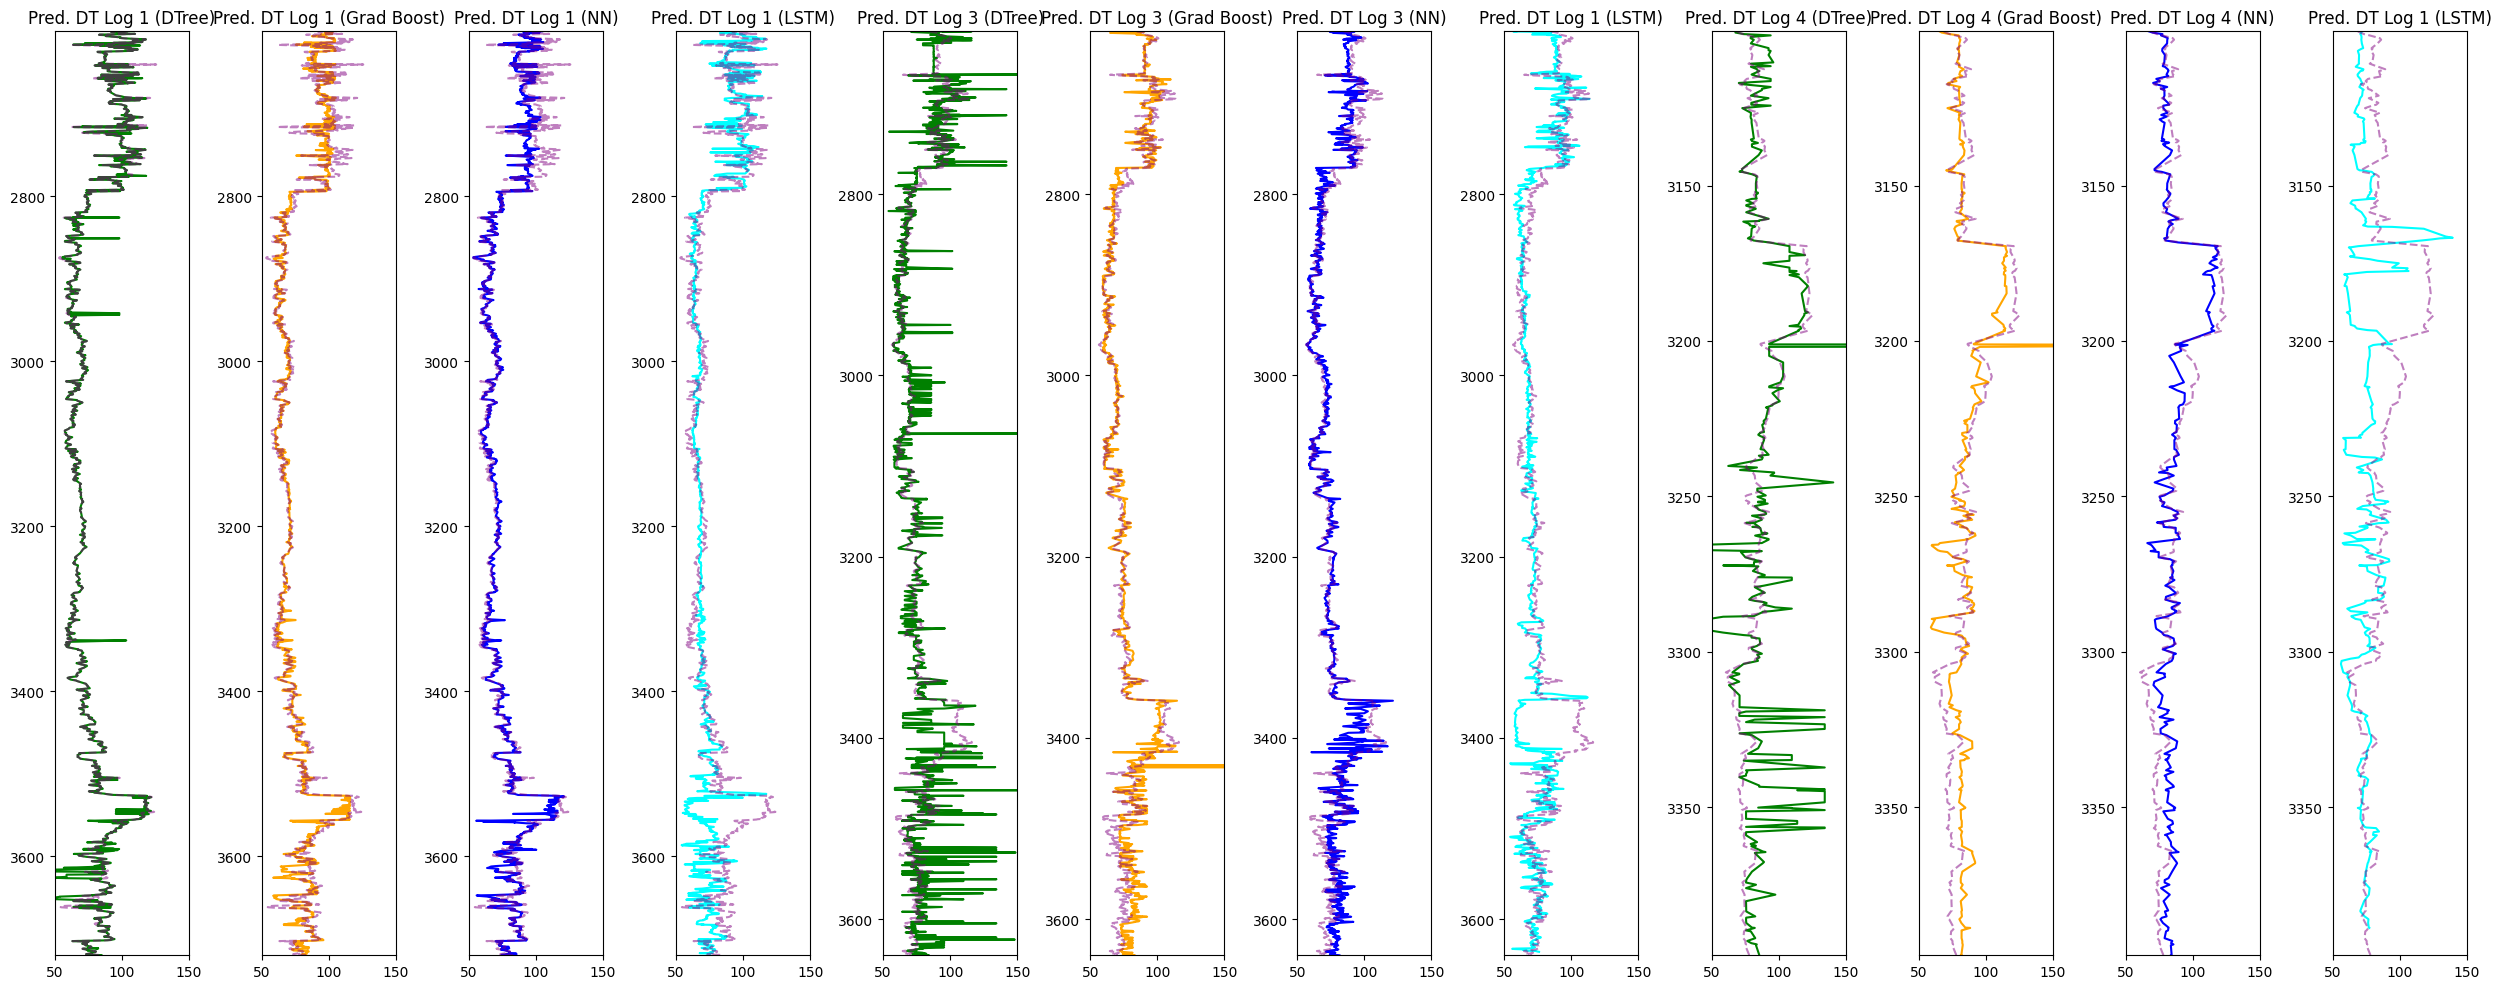

In [52]:
x_plott = [y_pred1_decision_tree_inv, y_pred1_grad_boost_inv, y_pred1_nn_inv,  y_pred1_lstm_inv,
           y_pred3_decision_tree_inv, y_pred3_grad_boost_inv, y_pred3_nn_inv,  y_pred3_lstm_inv,
           y_pred4_decision_tree_inv, y_pred4_grad_boost_inv, y_pred4_nn_inv,  y_pred4_lstm_inv]

x_real_plott = [
    y_val1,
    y_val3,
    y_val4
]

x_real_plott_lstm = [
    y_val1_lstm,
    y_val3_lstm,
    y_val4_lstm
]

y_plott = [train_preserve[train_preserve['WELL'] == '15_9-F-11A']['DEPTH'],
            train_preserve[train_preserve['WELL'] == '15_9-F-1A']['DEPTH'],
            train_preserve[train_preserve['WELL'] == '15_9-F-1B']['DEPTH']]

color_preds = ['green', 'orange', 'blue', 'cyan'] * 3
title_preds = ['Pred. DT Log 1 (DTree)', 'Pred. DT Log 1 (Grad Boost)', 'Pred. DT Log 1 (NN)',  'Pred. DT Log 1 (LSTM)',
               'Pred. DT Log 3 (DTree)', 'Pred. DT Log 3 (Grad Boost)', 'Pred. DT Log 3 (NN)',  'Pred. DT Log 1 (LSTM)',
               'Pred. DT Log 4 (DTree)', 'Pred. DT Log 4 (Grad Boost)', 'Pred. DT Log 4 (NN)',  'Pred. DT Log 1 (LSTM)',]

fig, ax = plt.subplots(nrows=1, ncols=12, figsize=(25, 10))

for i, (x_pred, title) in enumerate(zip(x_plott, title_preds)):
    # Reshape y[i] to match the shape of x_pred
    y_i_reshaped = y_plott[i//4]
    ax[i].plot(x_pred, y_i_reshaped[:len(x_pred)], color=color_preds[i])
    ax[i].plot(x_real_plott[i//4], y_i_reshaped, color='purple', linestyle='dashed', alpha = 0.5) #if i%4 != 0 else x_real_plott_lstm[i//4]
    ax[i].set_xlim(50, 150)
    ax[i].set_ylim(max(y_i_reshaped), min(y_i_reshaped))  # Ensure correct order of y-axis
    ax[i].set_title(title)

plt.tight_layout()
plt.show()


In [53]:
# Define the test data
names_test = ['15_9-F-11B', '15_9-F-1C']

X_test = []
y_test = []
depths = []

for i in range(len(names_test)):
  # split the df with respect to its name
  test = pred.loc[pred['WELL'] == names_test[i]]

  # Drop well name column
  test = test.drop(['WELL'], axis=1)

  # Define X_test (feature)
  X_test_ = test[feature_names].values

  # Define depth
  depth_ = test['DEPTH'].values

  X_test.append(X_test_)
  depths.append(depth_)

# For each well 2 and 5
X_test2, X_test5 = X_test
depth2, depth5 = depths

In [54]:
X_test2

array([[ 0.075,  2.605,  9.348,  8.331,  7.451,  8.547],
       [ 0.077,  2.602,  9.362,  8.289,  7.464,  8.547],
       [ 0.078,  2.599,  9.545,  8.247,  7.405,  8.547],
       ...,
       [ 0.103,  2.592, 32.217,  4.232,  4.729,  8.734],
       [ 0.108,  2.583, 29.841,  4.233,  4.705,  8.75 ],
       [ 0.114,  2.571, 31.423,  4.225,  4.617,  8.76 ]])

In [55]:
# Transform X_test of log 2 and 5
X_test2 = scaler.fit_transform(X_test2)
X_test5 = scaler.fit_transform(X_test5)

X_test2_lstm, _ = prep_for_lstm(X_test2, X_test2, time_steps = time_steps)
X_test5_lstm, _ = prep_for_lstm(X_test5, X_test5, time_steps = time_steps)


# Predictions for log 2 using all models
y_pred2_grad_boost = model_grad_boost.predict(X_test2)
y_pred2_decision_tree = model_decision_tree.predict(X_test2)
y_pred2_nn = model_nn.predict(X_test2)
y_pred2_lstm = model_lstm.predict(X_test2_lstm)
#y_pred2_transformer = model_transformer.predict(X_test2)

# Predictions for log 5 using all models
y_pred5_grad_boost = model_grad_boost.predict(X_test5)
y_pred5_decision_tree = model_decision_tree.predict(X_test5)
y_pred5_nn = model_nn.predict(X_test5)
y_pred5_lstm = model_lstm.predict(X_test5_lstm)
#y_pred5_transformer = model_transformer.predict(X_test5)

y = train[target_name].values
scaler.fit(y.reshape(-1,1))

# Inverse transform y_pred for log 2
y_pred2_grad_boost = scaler.inverse_transform(y_pred2_grad_boost.reshape(-1,1))
y_pred2_decision_tree = scaler.inverse_transform(y_pred2_decision_tree.reshape(-1,1))
y_pred2_nn = scaler.inverse_transform(y_pred2_nn.reshape(-1,1))
y_pred2_lstm = scaler.inverse_transform(y_pred2_lstm.reshape(-1,1))
#y_pred2_transformer = scaler.inverse_transform(y_pred2_transformer.reshape(-1,1))

# Inverse transform y_pred for log 5
y_pred5_grad_boost = scaler.inverse_transform(y_pred5_grad_boost.reshape(-1,1))
y_pred5_decision_tree = scaler.inverse_transform(y_pred5_decision_tree.reshape(-1,1))
y_pred5_nn = scaler.inverse_transform(y_pred5_nn.reshape(-1,1))
y_pred5_lstm = scaler.inverse_transform(y_pred5_lstm.reshape(-1,1))
#y_pred5_transformer = scaler.inverse_transform(y_pred5_transformer.reshape(-1,1))


297/297 [==============================] - 1s 5ms/step


In [56]:
def pad_predicted_values(predicted_values, target_column, window_size=10):
    """
    Pad the predicted values using a moving average to fill in the gaps.

    Parameters:
        predicted_values (np.ndarray): The predicted values to pad.
        target_column (pd.Series): The target column used to calculate moving average.
        window_size (int): The size of the moving average window.

    Returns:
        np.ndarray: The padded predicted values.
    """
    # Calculate the number of values to pad
    pad_length = len(target_column) - len(predicted_values)

    # Pad the predicted values with NaNs to match the length of target_column
    padding = np.full((pad_length, 1), np.nan)

    padded_values = np.concatenate((padding, predicted_values))

    for i in range(len(padded_values)-1, -1, -1):
        if np.isnan(padded_values[i][0]):
            padded_values[i][0] = np.mean(padded_values[i+1:i+1+window_size])



    return padded_values


In [57]:
y_pred2_lstm

array([[60.388477],
       [60.4415  ],
       [60.50837 ],
       ...,
       [56.933956],
       [56.628242],
       [56.744457]], dtype=float32)

In [58]:
pad_predicted_values(y_pred2_lstm, y_pred2_nn)

array([[60.67616904],
       [60.65483564],
       [60.64152053],
       ...,
       [56.93395615],
       [56.62824249],
       [56.74445724]])

In [59]:
# Add predictions for log 2 to the dataframes
log2['DT_grad_boost'] = y_pred2_grad_boost
log2['DT_Tree'] = y_pred2_decision_tree
log2['DT_nn'] = y_pred2_nn
log2['DT_lstm'] = pad_predicted_values(y_pred2_lstm, log2['DT_Tree'])


# Add predictions for log 5 to the dataframes
log5['DT_grad_boost'] = y_pred5_grad_boost
log5['DT_Tree'] = y_pred5_decision_tree
log5['DT_nn'] = y_pred5_nn
log5['DT_lstm'] = pad_predicted_values(y_pred5_lstm, log5['DT_Tree'])
#log5['DT_transformer'] = y_pred5_transformer


<ipython-input-59-b0e2fc4a4f3b>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  log5['DT_grad_boost'] = y_pred5_grad_boost
<ipython-input-59-b0e2fc4a4f3b>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  log5['DT_Tree'] = y_pred5_decision_tree
<ipython-input-59-b0e2fc4a4f3b>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stabl

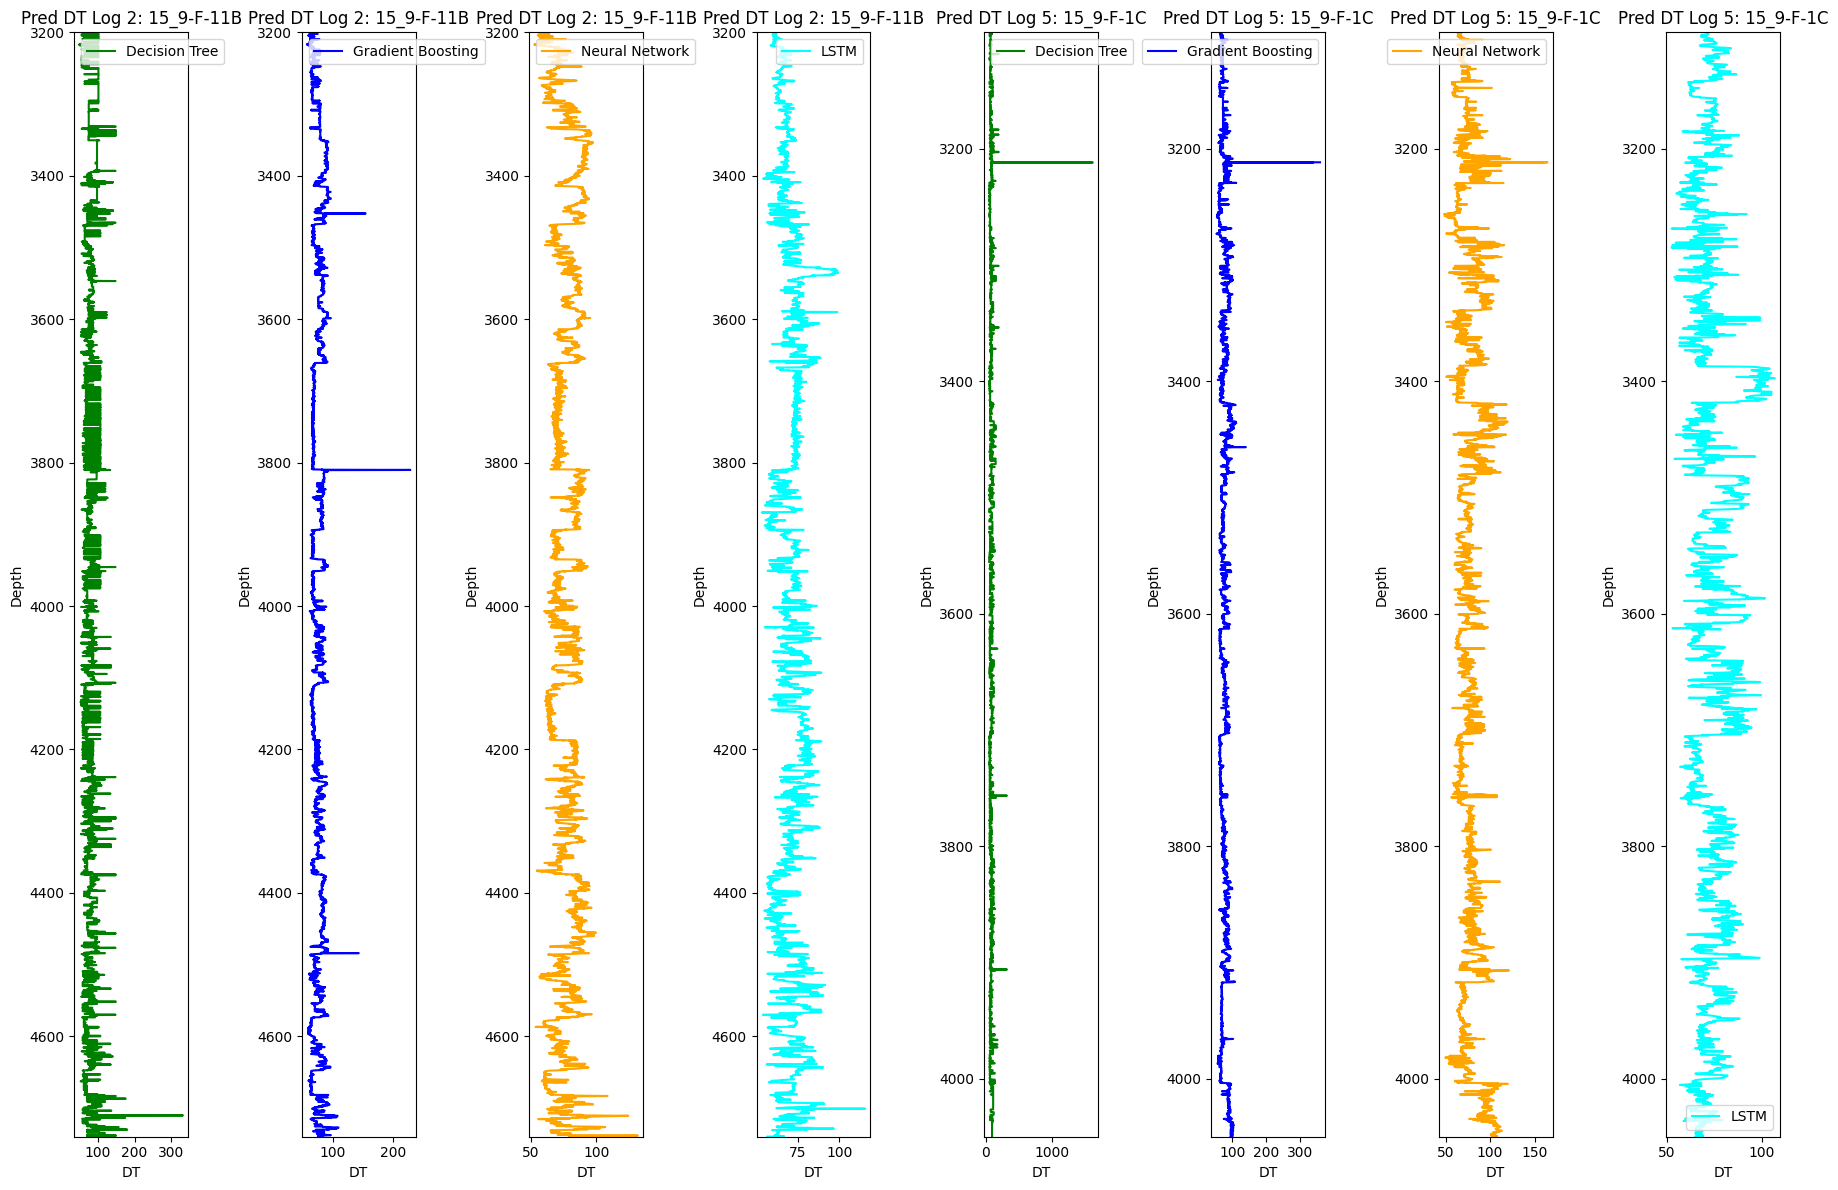

In [60]:
plt.figure(figsize=(18, 12))

# Plot predictions for log 2

plt.subplot(1, 8, 1)
plt.plot(y_pred2_decision_tree, depth2, color='green', label='Decision Tree')
plt.ylim(max(depth2), min(depth2))
plt.title('Pred DT Log 2: 15_9-F-11B', size=12)
plt.xlabel('DT')
plt.ylabel('Depth')
plt.legend()

plt.subplot(1, 8, 2)
plt.plot(y_pred2_grad_boost, depth2, color='blue', label='Gradient Boosting')
plt.ylim(max(depth2), min(depth2))
plt.title('Pred DT Log 2: 15_9-F-11B', size=12)
plt.xlabel('DT')
plt.ylabel('Depth')
plt.legend()


plt.subplot(1, 8, 3)
plt.plot(y_pred2_nn, depth2, color='orange', label='Neural Network')
plt.ylim(max(depth2), min(depth2))
plt.title('Pred DT Log 2: 15_9-F-11B', size=12)
plt.xlabel('DT')
plt.ylabel('Depth')
plt.legend()

plt.subplot(1, 8, 4)
plt.plot(pad_predicted_values(y_pred2_lstm, depth2), depth2, color='cyan', label='LSTM')
plt.ylim(max(depth2), min(depth2))
plt.title('Pred DT Log 2: 15_9-F-11B', size=12)
plt.xlabel('DT')
plt.ylabel('Depth')
plt.legend()

# For log 5

plt.subplot(1, 8, 5)
plt.plot(y_pred5_decision_tree, depth5, color='green', label='Decision Tree')
plt.ylim(max(depth5), min(depth5))
plt.title('Pred DT Log 5: 15_9-F-1C', size=12)
plt.xlabel('DT')
plt.ylabel('Depth')
plt.legend()


plt.subplot(1, 8, 6)
plt.plot(y_pred5_grad_boost, depth5, color='blue', label='Gradient Boosting')
plt.ylim(max(depth5), min(depth5))
plt.title('Pred DT Log 5: 15_9-F-1C', size=12)
plt.xlabel('DT')
plt.ylabel('Depth')
plt.legend()


plt.subplot(1, 8, 7)
plt.plot(y_pred5_nn, depth5, color='orange', label='Neural Network')
plt.ylim(max(depth5), min(depth5))
plt.title('Pred DT Log 5: 15_9-F-1C', size=12)
plt.xlabel('DT')
plt.ylabel('Depth')
plt.legend()

plt.subplot(1, 8, 8)
plt.plot(pad_predicted_values(y_pred5_lstm, depth5), depth5, color='cyan', label='LSTM')
plt.ylim(max(depth5), min(depth5))
plt.title('Pred DT Log 5: 15_9-F-1C', size=12)
plt.xlabel('DT')
plt.ylabel('Depth')
plt.legend()


plt.tight_layout()
plt.show()


In [61]:
def makeplotpred(df, color_list, suptitle_str="Pass a suptitle"):
    # Column selection from df
    col_names = ['NPHI', 'RHOB', 'GR', 'RT', 'PEF', 'CALI', 'DT_Tree', 'DT_grad_boost', 'DT_nn', 'DT_lstm']
    # Plotting titles
    title = ['NPHI', 'RHOB', 'GR', 'RT', 'PEF', 'CALI', 'Predicted DT Decsion Tree', 'Predicted DT GB', 'Predicted DT NN', 'Predicted DT LSTM']

    # Create the subplots; ncols equals the number of logs
    fig, ax = plt.subplots(nrows=1, ncols=len(col_names), figsize=(20,15))
    fig.suptitle(suptitle_str, size=20, y=1.05)

    # Looping each log to display in the subplots
    for i in range(len(col_names)):
        if i == 3:
            # for resistivity, semilog plot
            ax[i].semilogx(df[col_names[i]], df['DEPTH'], color=color_list[i])

        else:
            # for non-resistivity, normal plot
            ax[i].plot(df[col_names[i]], df['DEPTH'], color=color_list[i])

        ax[i].set_ylim(max(df['DEPTH']), min(df['DEPTH']))
        ax[i].set_title(title[i], pad=15)
        ax[i].grid(True)
        ax[i].legend()

    ax[2].set_xlim(0, 200)
    plt.tight_layout()
    plt.show()

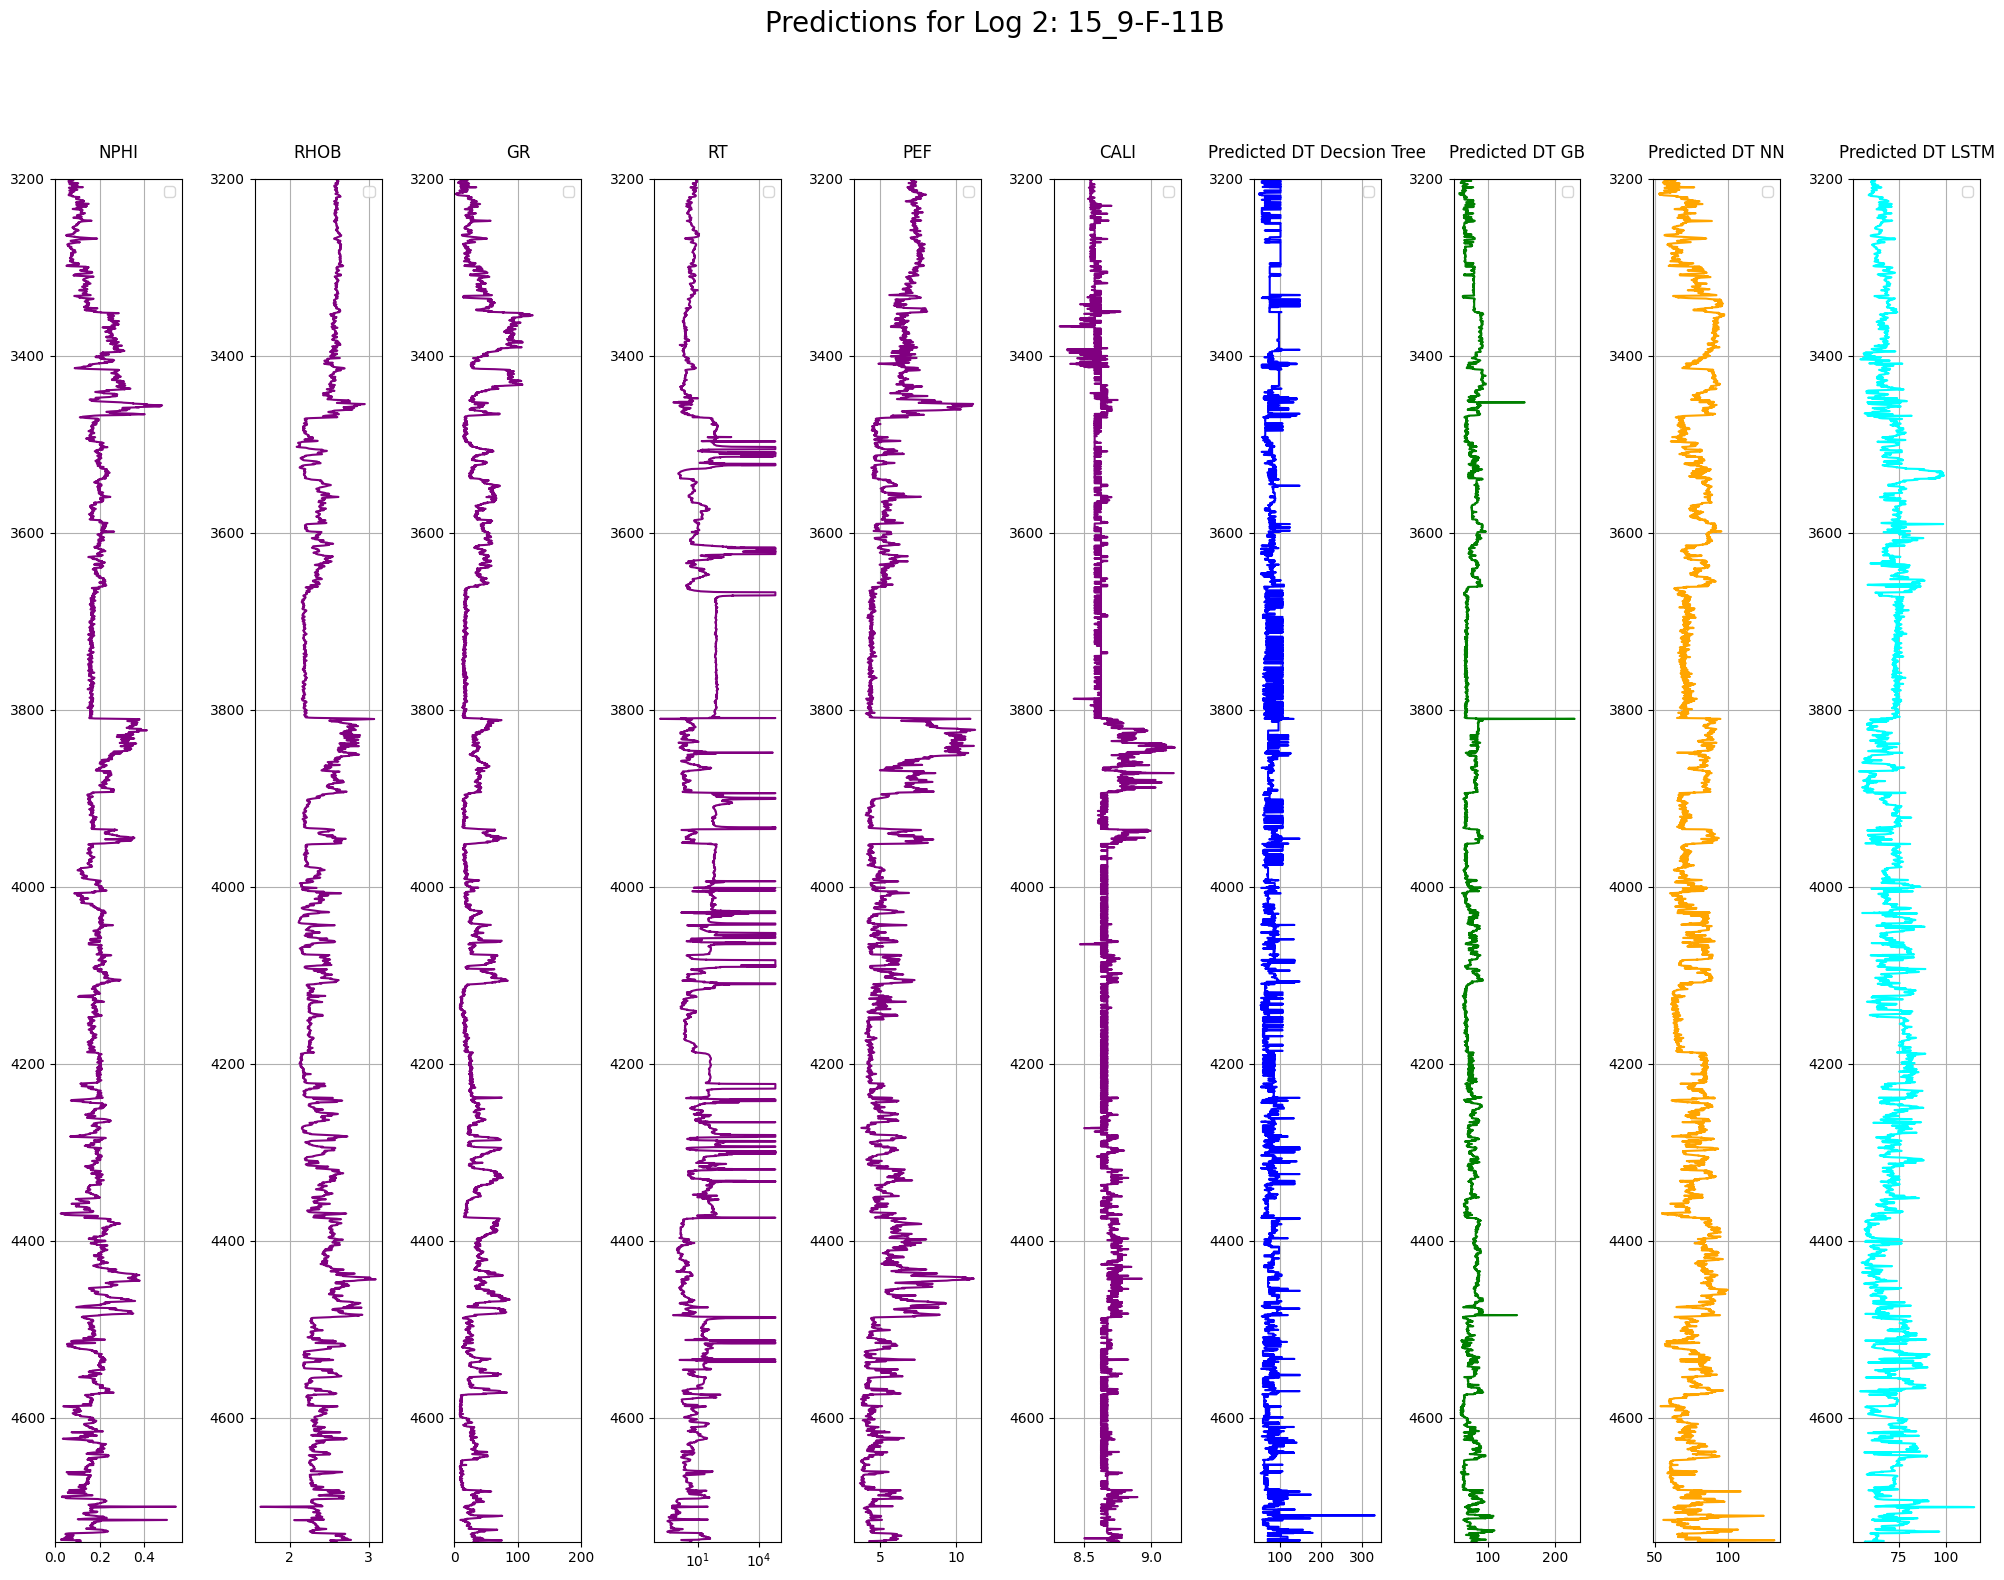

In [62]:
# Assuming `depth` is the depth information shared among all logs
makeplotpred(log2,
             ['purple', 'purple', 'purple', 'purple', 'purple', 'purple',  'blue', 'green',  'orange', 'cyan'],
             suptitle_str="Predictions for Log 2: 15_9-F-11B")

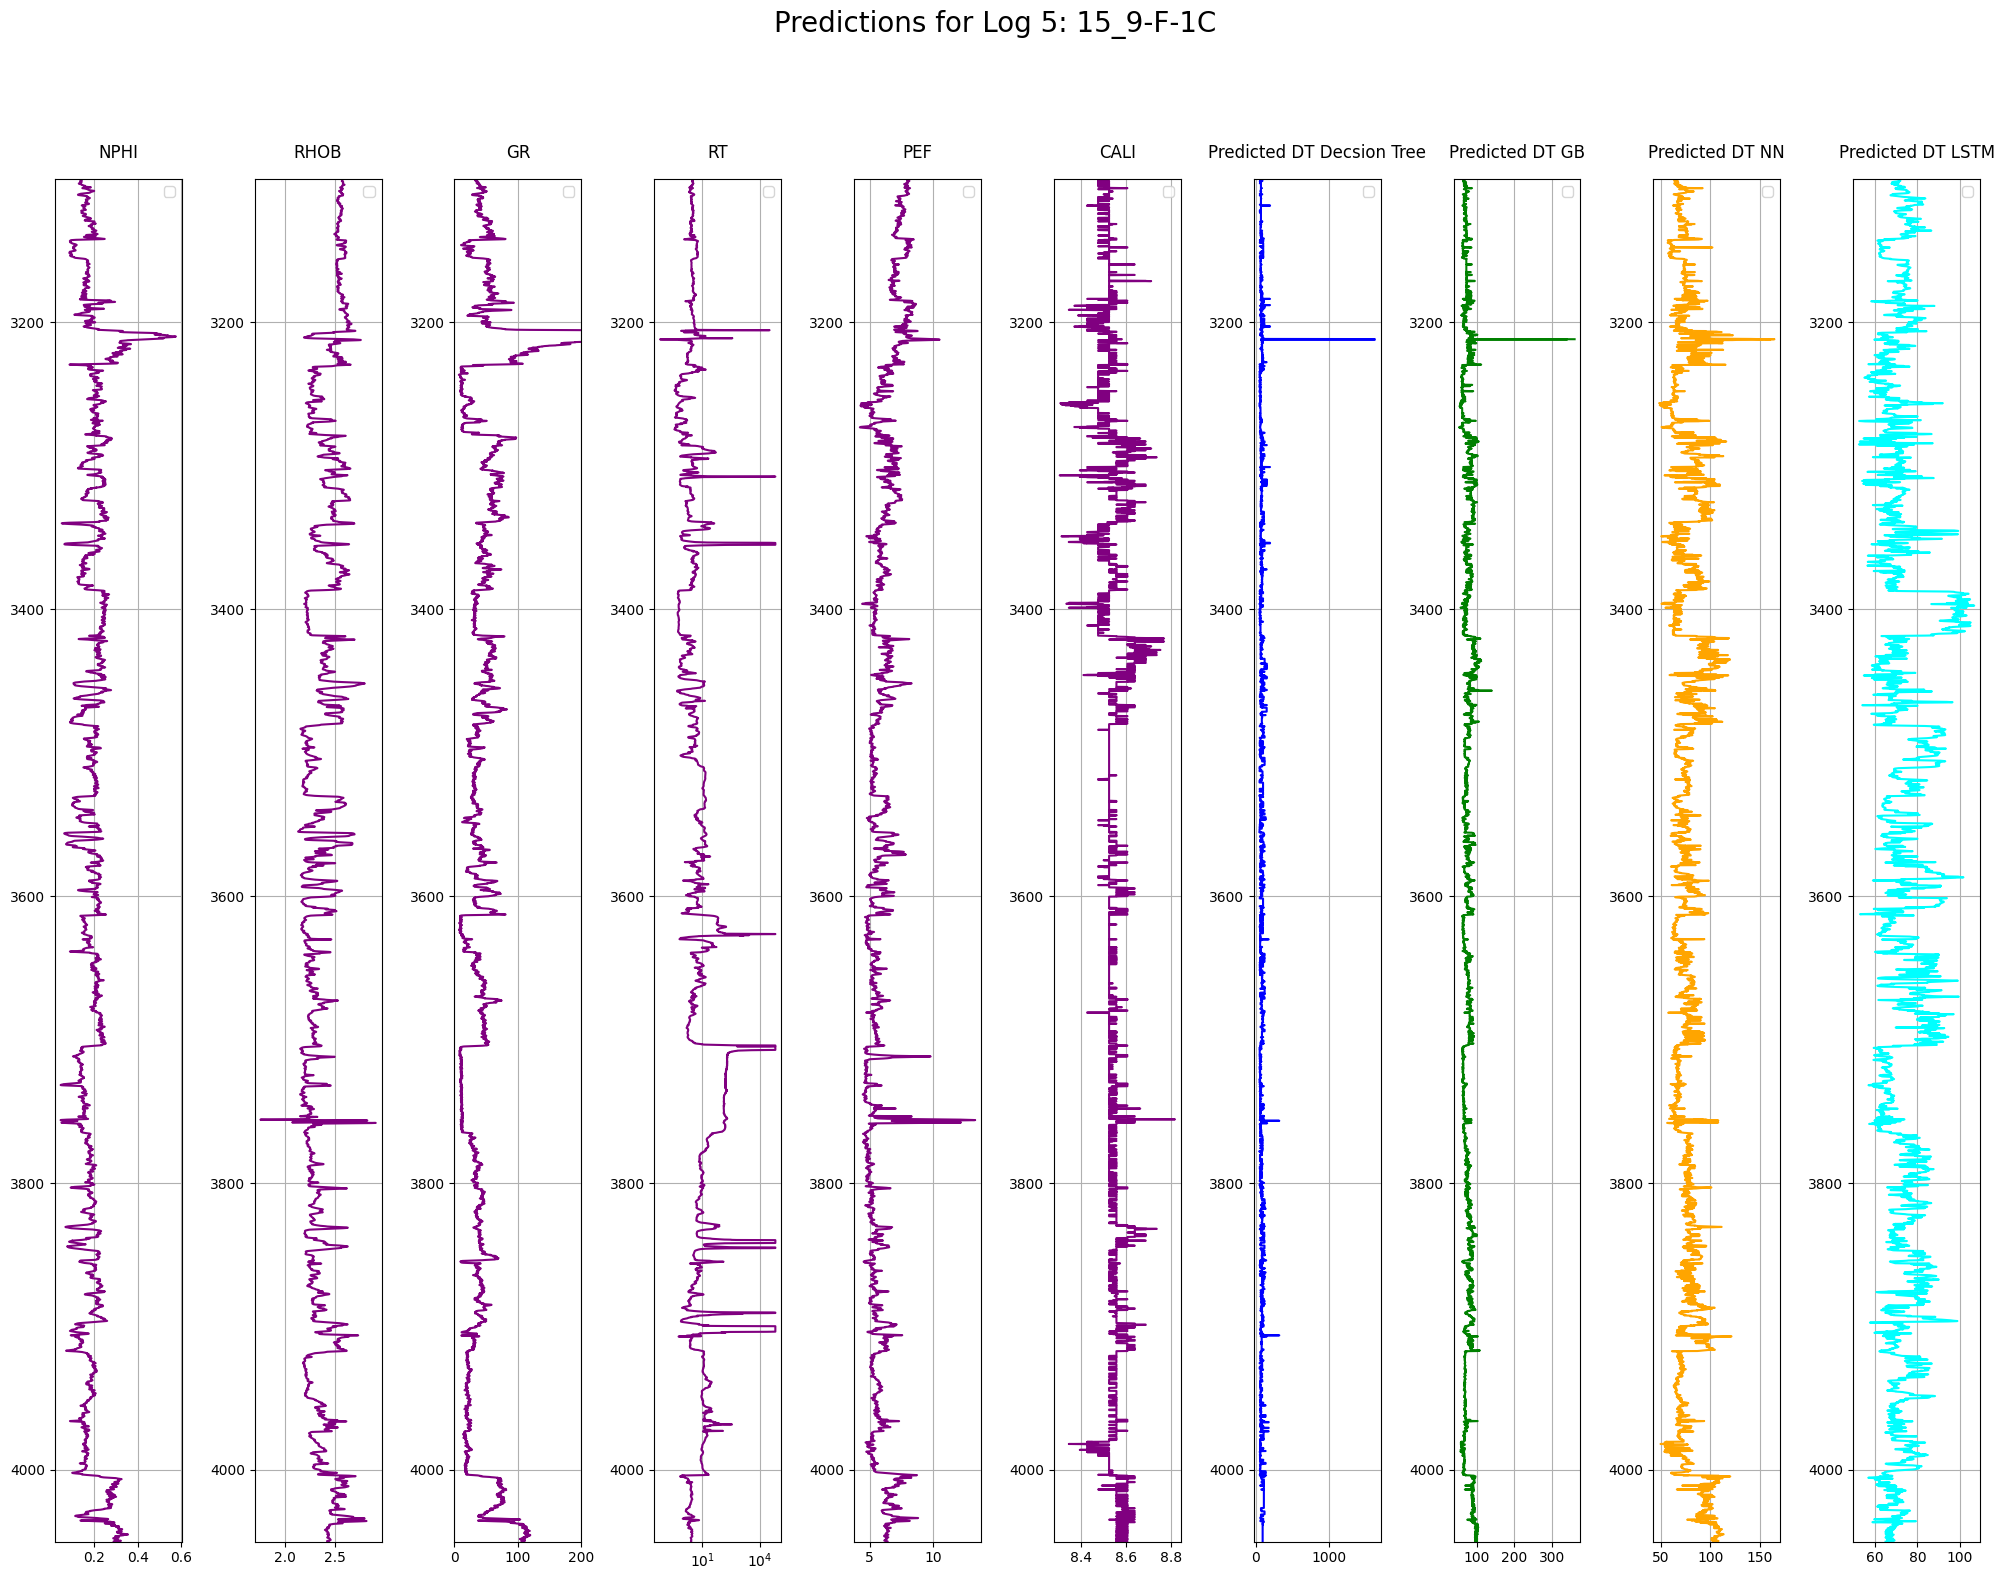

In [63]:
makeplotpred(log5,
             ['purple', 'purple', 'purple', 'purple', 'purple', 'purple',  'blue',  'green', 'orange', 'cyan'],
             suptitle_str="Predictions for Log 5: 15_9-F-1C")